In [1]:
!pip install pycona
import pandas as pd
from pycona import *

## Preparing the problem instances

In constraint acquisition (CA), the user wants to model a given problem instance, and the CA system assists in finding the constraints of the problem. To run a CA system, the user has to model the variables (with their domains) of the problem, and provide also a language, consisting of constraint relations that could possibly exist in the problem. 

As **PyConA** is using the CPMpy modeling library (https://github.com/CPMpy/cpmpy), the variables and language must be CPMpy variables and expressions. 

For variables, we can use any type of variable supported in CPMpy, e.g. for integer variables we can create them as follows:

In [2]:
import cpmpy as cp

# Define the variables
int_vars = cp.intvar(1, 4, shape=(4,4), name="var")  # lower bound, upper bound, shape, variable names
print(int_vars)

[[var[0,0] var[0,1] var[0,2] var[0,3]]
 [var[1,0] var[1,1] var[1,2] var[1,3]]
 [var[2,0] var[2,1] var[2,2] var[2,3]]
 [var[3,0] var[3,1] var[3,2] var[3,3]]]


For creating the language, we need to define abstract relations, which will then be used to generate the ground candidate constraints (bias) of the given instance.

In **PyConA**, we have defined a new type of variables: abstract variables. They can be used to create the abstract relations of the language:

In [3]:
AV = absvar(2)  # create abstract vars - as many as maximum arity

# create abstract relations using the abstract vars
language = [AV[0] == AV[1],
            AV[0] != AV[1], 
            AV[0] < AV[1], 
            AV[0] > AV[1], 
            AV[0] >= AV[1], 
            AV[0] <= AV[1]]

We have some predefined languages that can be used by the user as follows (the above is langBasic):

In [4]:
#langEqNeq = [AV[0] == AV[1], AV[0] != AV[1]]

#langBasic = [AV[0] == AV[1], AV[0] != AV[1], AV[0] < AV[1], AV[0] > AV[1], AV[0] >= AV[1], AV[0] <= AV[1]]

#langDist = [AV[0] == AV[1], AV[0] != AV[1], AV[0] < AV[1], AV[0] > AV[1], AV[0] >= AV[1], AV[0] <= AV[1], 
            # abs(AV[0] - AV[1]) != abs(AV[2] - AV[3]), abs(AV[0] - AV[1]) == abs(AV[2] - AV[3])]

In **PyConA**, all input information for the problem at hand is encaptulated with the *ProblemInstance* class. Let's see this with the following (running) example, using the nurse rostering problem:

In [5]:
import cpmpy as cp

def construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift):

    # Define the variables
    roster_matrix = cp.intvar(1, num_nurses, shape=(num_days, shifts_per_day, nurses_per_shift), 
                              name="shifts")


    # Create the language:
    AV = absvar(2)  # create abstract vars - as many as maximum arity
    # create abstract relations using the abstract vars
    lang = [AV[0] == AV[1], AV[0] != AV[1], AV[0] < AV[1], AV[0] > AV[1], AV[0] >= AV[1], AV[0] <= AV[1]]

    instance = ProblemInstance(variables=roster_matrix, language=lang)

    return instance

Using our function *construct_nurse_rostering()*, we can create a nurse rostering ProblemInstance, which we can in turn give to a CA system to find the constraints via interaction with the user.

In [6]:
instance = construct_nurse_rostering(3, 2, 8, 2)
print(instance)

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Language: [(AV6) == (AV7), (AV6) != (AV7), (AV6) < (AV7), (AV6) > (AV7), (AV6) >= (AV7), (AV6) <= (AV7)].


If we want to avoid answering the queries ourselves, we can simulate this process using an oracle. In **PyConA**, we can define a new oracle based on a software system by subclassing the *Oracle* class, or we can use a *ConstraintOracle* to simulate the user in our experiments, using the target set of constraints.

Lets adjust our *construct_nurse_rostering()* function to also return an oracle:

In [7]:
def construct_nurse_rostering_with_oracle(shifts_per_day, num_days, num_nurses, nurses_per_shift):
    
    inst = construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift)
    
    # Create an oracle for simulation, by defining the ground truth problem
    ## Define the variables
    roster_matrix = inst.variables
    
    ## Define the list of (fixed-arity/decomposed) constraints
    C_T = []

    ## Constraint: Each shift in a day must be assigned to a different nurse
    for day in range(num_days):
        C_T += cp.AllDifferent(roster_matrix[day, ...]).decompose()   # ... means all remaining dimensions

    ## Constraint: The last shift of a day cannot have the same nurse as the first shift of the next day
    for day in range(num_days - 1):
        C_T += cp.AllDifferent(roster_matrix[day, shifts_per_day - 1], roster_matrix[day + 1, 0]).decompose()

    oracle = ConstraintOracle(C_T)

    return inst, oracle

Now we have our instance, which we can use as input in a CA system, and an oracle to simulate the user answers

## Constraint Acquisition Systems

Currently only interactive CA systems are supported by **PyConA**. The core of interactive CA systems is the *AlgorithmCAInteractive* class. This is subclassed with different algorithms presented in the literature. Each interactive CA algorithm can be configured in different ways for each of the 3 main subcomponents of interactive CA systems:

- Query Generation: The query generation system to be used to generate top-level queries.
- FindScope: The FindScope system to be used for finding the scope of violated constraints.
- FindConstraint: The FindConstraint system to be used for finding the exact violated constraints in the given scopes.

For each of the subcomponents several choices are implemented, based on the literature.

For this introductory example, we will use GrowAcq as the algorithm and we will stick to its default behaviour: PQGen for query generation, FindScope2 for finding the scope, and FindC for finding the exact constraint in the given scope.

Let's now create our GrowAcq system. To run a CA system, i.e., start the learning process, we need to call its learn() method, which needs as parameter the instance we want to acquire the constraints for, while it can optionally take as argument also the labeller (i.e., the oracle we created). The default oracle is the human user. 

The learn() method will return the updated ProblemInstance, with the learned constraints.

In [8]:
instance, oracle = construct_nurse_rostering_with_oracle(3, 2, 8, 2)

ca = GrowAcq()
learned_instance = ca.learn(instance, oracle=oracle, verbose=1)

Running growacq with <pycona.active_algorithms.mquacq2.MQuAcq2 object at 0x000001988FBA4E80> as inner algorithm

Learned 0 constraints in 0 queries.
...L..
Learned 1 constraints in 5 queries.
...L.L
Learned 3 constraints in 9 queries.
...L.L.L
Learned 6 constraints in 14 queries.
...L.L.L.L
Learned 10 constraints in 20 queries.
...L.L.L.L.L
Learned 15 constraints in 27 queries.
......L..L
Learned 17 constraints in 35 queries.
......L...L.L
Learned 20 constraints in 45 queries.
.........L.L
Learned 22 constraints in 55 queries.
.......L.L.L
Learned 25 constraints in 64 queries.
.....L...L.L.L
Learned 29 constraints in 74 queries.
.....L.L.L.L.L..
Learned 34 constraints in 85 queries.


We can see the learned constraints of the instance:

In [9]:
print(learned_instance)

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Constraints: [(shifts[0,0,1]) != (shifts[0,0,0]), (shifts[0,1,0]) != (shifts[0,0,0]), (shifts[0,1,0]) != (shifts[0,0,1]), (shifts[0,1,1]) != (shifts[0,1,0]), (shifts[0,1,1]) != (shifts[0,0,0]), (shifts[0,1,1]) != (shifts[0,0,1]), (shifts[0,2,0]) != (shifts[0,1,0]), (shifts[0,2,0]) != (shifts[0,1,1]), (shifts[0,2,0]) != (shifts[0,0,0]), (shifts[0,2,0]) != (shifts[0,0,1]), (shifts[0,2,1]) != (shifts[0,0,0]), (shifts[0,2,1]) != (shifts[0,1,0]), (shifts[0,2,1]) != (shifts[0,0,1]), (shifts[0,2,1]) != (shifts[0,1,1]), (shifts[0,2,1]) != (shifts[0,2,0]), (shifts[1,0,0]) != (shifts[0,2,0]), (shifts[1,0,0]) != (shifts[0,2,1]), (shifts[1,0,1]) != (shifts[1,0,0]), (shifts[1,0,1]) != (shifts[0,2,0]), (shifts[1,0,1]) != (shifts[0,2,1]), (shifts[1,1,0]) != (shifts[1,0,0]), (s

If we want to inspect closer the learning process, we can increase the verbosity level of the CA System:

In [10]:
learned_instance =  ca.learn(instance, oracle=oracle, verbose=3)

Running growacq with <pycona.active_algorithms.mquacq2.MQuAcq2 object at 0x000001988FBA4E80> as inner algorithm
Added variable shifts[0,0,0] in GrowAcq
size of B in growacq:  0

GrowAcq: calling inner_algorithm for 1/12 variables

Learned 0 constraints in 0 queries.
C_L:  0
B:  0
Number of queries:  0
Top level Queries:  0
FindScope Queries:  0
FindC Queries:  0
Added variable shifts[0,0,1] in GrowAcq
size of B in growacq:  6

GrowAcq: calling inner_algorithm for 2/12 variables
Size of CL:  0
Size of B:  6
Number of queries:  0
MQuAcq-2 Queries:  0
FindScope Queries:  0
FindC Queries:  0
Query0: is this a solution?
[[[1 1]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  No
Query1: is this a solution?
[[[1 2]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) < (shifts[0,0,0])]
Query2: is this a solution?
[[[8 6]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias:

Size of CL:  10
Size of B:  30
Number of queries:  20
MQuAcq-2 Queries:  18
FindScope Queries:  0
FindC Queries:  2
Query20: is this a solution?
[[[2 6]
  [8 7]
  [1 3]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) == (shifts[0,1,0]), (shifts[0,2,1]) == (shifts[0,2,0]), (shifts[0,2,1]) == (shifts[0,0,1]), (shifts[0,2,1]) == (shifts[0,0,0]), (shifts[0,2,1]) == (shifts[0,1,1]), (shifts[0,2,1]) < (shifts[0,2,0]), (shifts[0,2,1]) < (shifts[0,0,0]), (shifts[0,2,1]) > (shifts[0,1,0]), (shifts[0,2,1]) > (shifts[0,0,1]), (shifts[0,2,1]) > (shifts[0,1,1]), (shifts[0,2,1]) >= (shifts[0,1,0]), (shifts[0,2,1]) >= (shifts[0,0,1]), (shifts[0,2,1]) >= (shifts[0,1,1]), (shifts[0,2,1]) <= (shifts[0,2,0]), (shifts[0,2,1]) <= (shifts[0,0,0])]
Size of CL:  10
Size of B:  15
Number of queries:  21
MQuAcq-2 Queries:  19
FindScope Queries:  0
FindC Queries:  2
Query21: is this a solution?
[[[5 2]
  [3 1]
  [6 4]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Ye

Size of CL:  17
Size of B:  3
Number of queries:  37
MQuAcq-2 Queries:  35
FindScope Queries:  0
FindC Queries:  2
Query37: is this a solution?
[[[0 0]
  [0 0]
  [1 3]]

 [[2 2]
  [0 0]
  [0 0]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,0,0])]
Size of CL:  18
Size of B:  2
Number of queries:  38
MQuAcq-2 Queries:  36
FindScope Queries:  0
FindC Queries:  2
Query38: is this a solution?
[[[0 0]
  [0 0]
  [1 2]]

 [[0 1]
  [0 0]
  [0 0]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[0,2,0])]
Size of CL:  19
Size of B:  1
Number of queries:  39
MQuAcq-2 Queries:  37
FindScope Queries:  0
FindC Queries:  2
Query39: is this a solution?
[[[0 0]
  [0 0]
  [0 1]]

 [[0 1]
  [0 0]
  [0 0]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[0,2,1])]

Learned 20 constraints in 40 queries.
C_L:  20
B:  0
Number of queries:  40
Top level Queries:  38
FindScope Queries:  0
FindC Queries:  2
Ad

Size of CL:  23
Size of B:  2
Number of queries:  55
MQuAcq-2 Queries:  53
FindScope Queries:  0
FindC Queries:  2
Query55: is this a solution?
[[[0 0]
  [0 0]
  [0 0]]

 [[1 2]
  [0 1]
  [0 0]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,0,0])]
Size of CL:  24
Size of B:  1
Number of queries:  56
MQuAcq-2 Queries:  54
FindScope Queries:  0
FindC Queries:  2
Query56: is this a solution?
[[[0 0]
  [0 0]
  [0 0]]

 [[0 1]
  [0 1]
  [0 0]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,0,1])]

Learned 25 constraints in 57 queries.
C_L:  25
B:  0
Number of queries:  57
Top level Queries:  55
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,2,0] in GrowAcq
size of B in growacq:  60

GrowAcq: calling inner_algorithm for 11/12 variables
Size of CL:  25
Size of B:  60
Number of queries:  57
MQuAcq-2 Queries:  55
FindScope Queries:  0
FindC Queries:  2
Query57: is this a solution?
[[[1 6]
  [7 3]
  [5 2]

Size of CL:  29
Size of B:  9
Number of queries:  70
MQuAcq-2 Queries:  68
FindScope Queries:  0
FindC Queries:  2
Query70: is this a solution?
[[[1 2]
  [0 0]
  [3 8]]

 [[7 4]
  [1 6]
  [5 3]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,2,0])]
Size of CL:  29
Size of B:  8
Number of queries:  71
MQuAcq-2 Queries:  69
FindScope Queries:  0
FindC Queries:  2
Query71: is this a solution?
[[[2 1]
  [0 0]
  [0 3]]

 [[1 4]
  [2 5]
  [6 3]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,2,1])]
Size of CL:  29
Size of B:  7
Number of queries:  72
MQuAcq-2 Queries:  70
FindScope Queries:  0
FindC Queries:  2
Query72: is this a solution?
[[[1 4]
  [0 0]
  [0 0]]

 [[6 4]
  [1 2]
  [3 2]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,1,1])]
Size of CL:  30
Size of B:  6
Number of queries:  73
MQuAcq-2 Queries:  71
FindScope Queries:  0
FindC Queries:  2
Query73: is thi

Having learned the constraints of the problem, we can get the cpmpy model from our instance and solve it to get a solution for our problem

In [11]:
m = learned_instance.get_cpmpy_model()
m.solve()

print(learned_instance.variables.value())

[[[8 7]
  [6 5]
  [4 3]]

 [[2 1]
  [6 5]
  [4 3]]]


### Visualizing the solutions and queries

An advantage of **PyConA** is that visualizations of solutions can be done quite easily, using standard libraries in python. Let's now define our visualize function for our nurse rostering problem, and visualize the solution found before: 

In [12]:

import pandas as pd
import matplotlib.pyplot as plt


def visualize_nurse_rostering(shifts):
    num_days, shifts_per_day, nurses_per_shift = shifts.shape
    num_nurses = shifts.max()  # Assuming nurse IDs are from 1 to num_nurses

    # Create an empty DataFrame with nurses as rows and days as columns
    columns = [f'Day {j} Shift {k}' for j in range(num_days) for k in range(shifts_per_day)]
    df = pd.DataFrame(index=[f'Nurse {i+1}' for i in range(num_nurses)], columns=columns)

    # Fill the DataFrame with shift information
    for day in range(num_days):
        for shift in range(shifts_per_day):
            for nurse in range(nurses_per_shift):
                nurse_id = shifts[day, shift, nurse]
                df.at[f'Nurse {nurse_id}', f'Day {day} Shift {shift}'] = 'Assigned'

    # Fill 'Not Assigned' for nurses who are not assigned to a shift
    df = df.fillna('Not Assigned')

    # Create a color map to highlight assigned shifts
    cmap = {'Assigned': 'lightgreen', 'Not Assigned': 'white'}

    # Create a new DataFrame to store colors
    df_colors = df.applymap(lambda x: cmap[x])

    # Calculate figure size dynamically
    fig_width = max(12, num_days * shifts_per_day * 1.5)  # Adjust width scaling factor as needed
    fig_height = max(2, num_nurses * 0.2)  # Adjust height scaling factor as needed

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create a table plot
    table = ax.table(cellText=df.values, cellColours=df_colors.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    ax.axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)  # Adjust the subplot parameters

    plt.show()


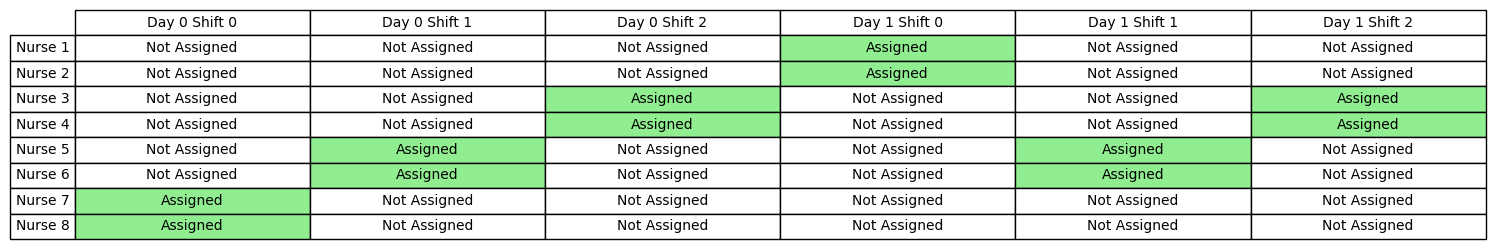

In [13]:
visualize_nurse_rostering(instance.variables.value())

In **PyConA**, we can also modify the way a query is displayed, to be more user-friendly and problem-oriented. If we create our own "visualize" function for the given problem, we can pass it to the *ProblemInstance* object by setting its "visualize" property. If you do not pass any, the default visualize function used is a simple print.

In [14]:
instance.visualize = visualize_nurse_rostering

Running growacq with <pycona.active_algorithms.mquacq2.MQuAcq2 object at 0x000001988FBA4E80> as inner algorithm
Added variable shifts[0,0,0] in GrowAcq
size of B in growacq:  0

GrowAcq: calling inner_algorithm for 1/12 variables

Learned 0 constraints in 0 queries.
C_L:  0
B:  0
Number of queries:  0
Top level Queries:  0
FindScope Queries:  0
FindC Queries:  0
Added variable shifts[0,0,1] in GrowAcq
size of B in growacq:  6

GrowAcq: calling inner_algorithm for 2/12 variables
Size of CL:  0
Size of B:  6
Number of queries:  0
MQuAcq-2 Queries:  0
FindScope Queries:  0
FindC Queries:  0
Query0: is this a solution?


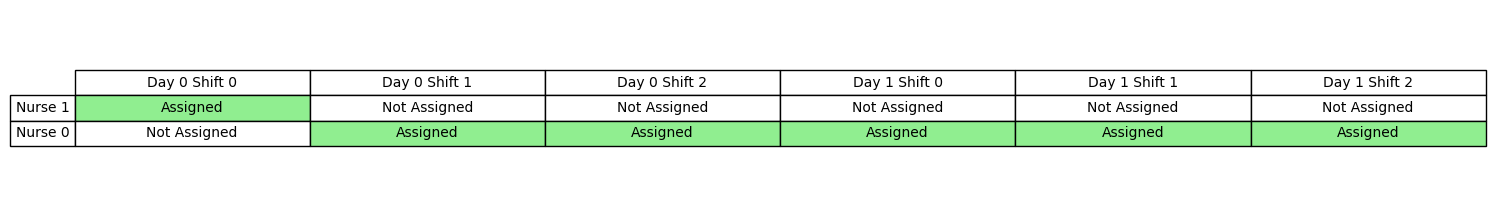

Answer:  No
Query1: is this a solution?


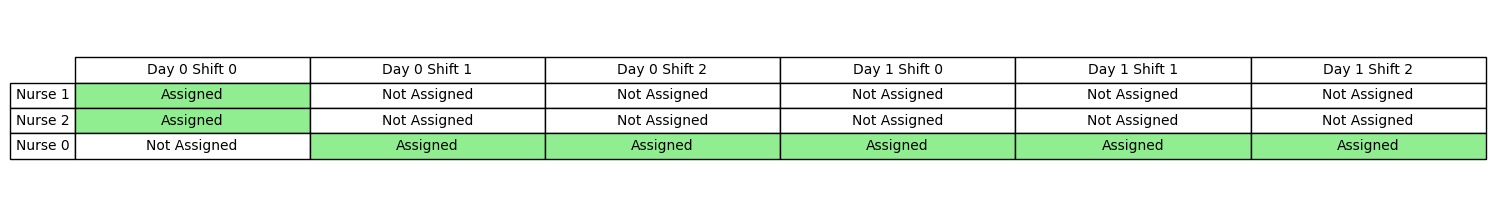

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) < (shifts[0,0,0])]
Query2: is this a solution?


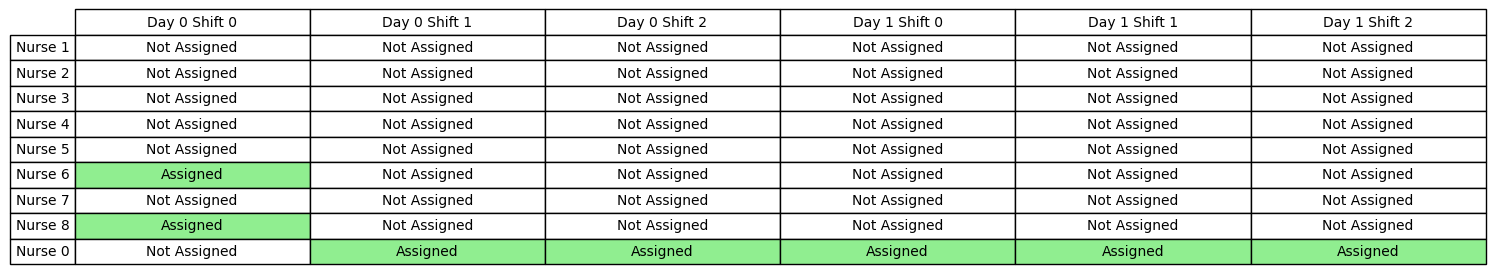

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) > (shifts[0,0,0])]
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,0,0])]
Size of CL:  1
Size of B:  3
Number of queries:  3
MQuAcq-2 Queries:  1
FindScope Queries:  0
FindC Queries:  2
Query3: is this a solution?


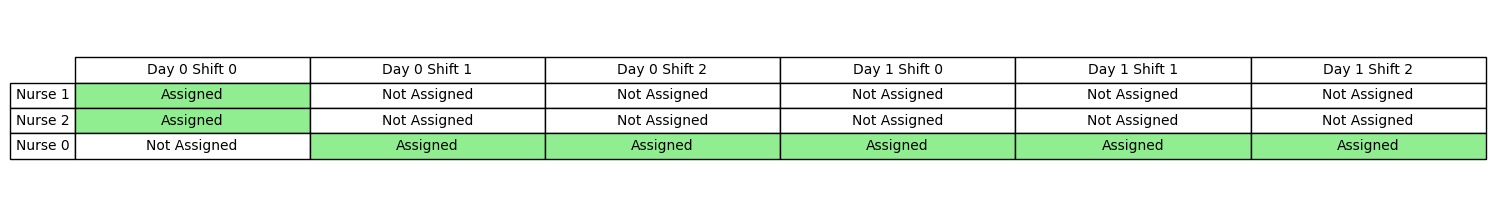

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) == (shifts[0,0,0]), (shifts[0,0,1]) <= (shifts[0,0,0])]
Size of CL:  1
Size of B:  1
Number of queries:  4
MQuAcq-2 Queries:  2
FindScope Queries:  0
FindC Queries:  2
Query4: is this a solution?


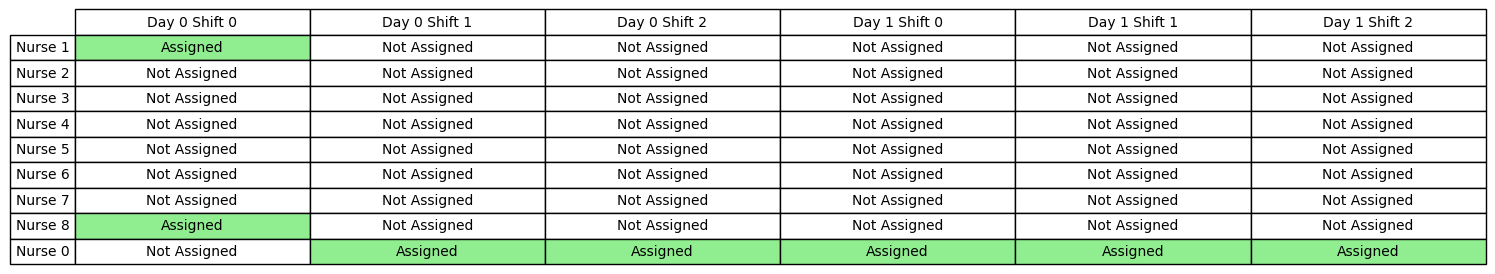

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) >= (shifts[0,0,0])]

Learned 1 constraints in 5 queries.
C_L:  1
B:  0
Number of queries:  5
Top level Queries:  3
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[0,1,0] in GrowAcq
size of B in growacq:  12

GrowAcq: calling inner_algorithm for 3/12 variables
Size of CL:  1
Size of B:  12
Number of queries:  5
MQuAcq-2 Queries:  3
FindScope Queries:  0
FindC Queries:  2
Query5: is this a solution?


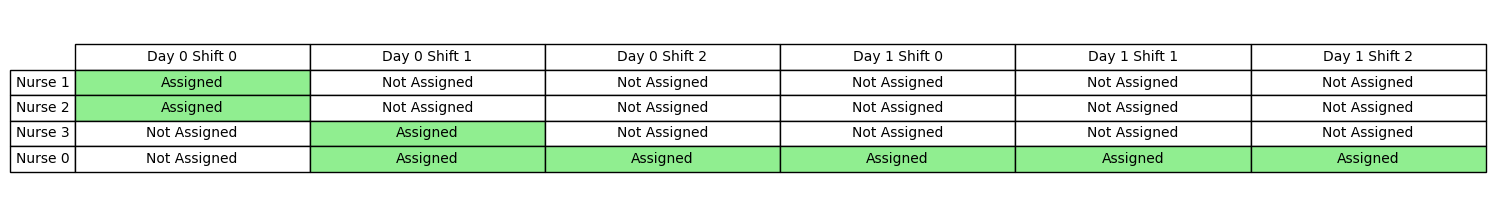

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) == (shifts[0,0,0]), (shifts[0,1,0]) == (shifts[0,0,1]), (shifts[0,1,0]) < (shifts[0,0,0]), (shifts[0,1,0]) < (shifts[0,0,1]), (shifts[0,1,0]) <= (shifts[0,0,0]), (shifts[0,1,0]) <= (shifts[0,0,1])]
Size of CL:  1
Size of B:  6
Number of queries:  6
MQuAcq-2 Queries:  4
FindScope Queries:  0
FindC Queries:  2
Query6: is this a solution?


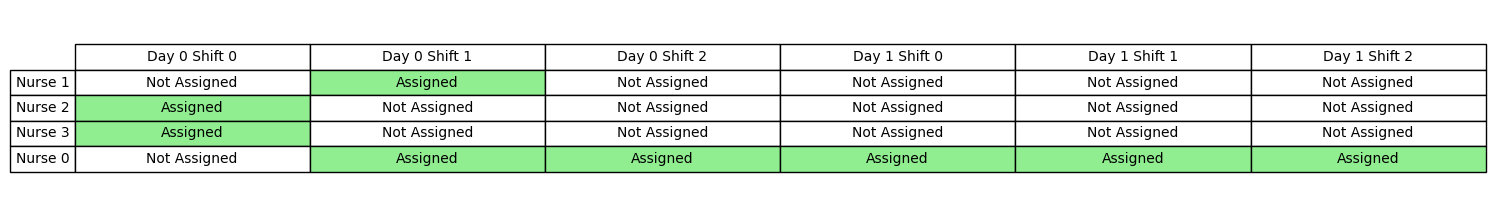

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[0,0,0]), (shifts[0,1,0]) >= (shifts[0,0,0]), (shifts[0,1,0]) >= (shifts[0,0,1]), (shifts[0,1,0]) > (shifts[0,0,1])]
Size of CL:  1
Size of B:  2
Number of queries:  7
MQuAcq-2 Queries:  5
FindScope Queries:  0
FindC Queries:  2
Query7: is this a solution?


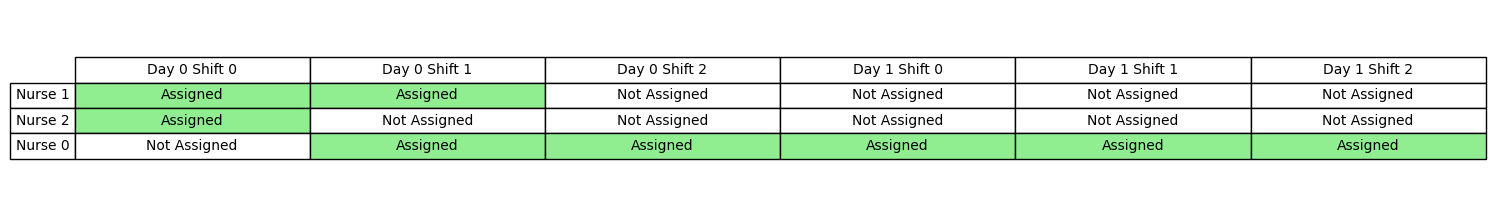

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,0,0])]
Size of CL:  2
Size of B:  1
Number of queries:  8
MQuAcq-2 Queries:  6
FindScope Queries:  0
FindC Queries:  2
Query8: is this a solution?


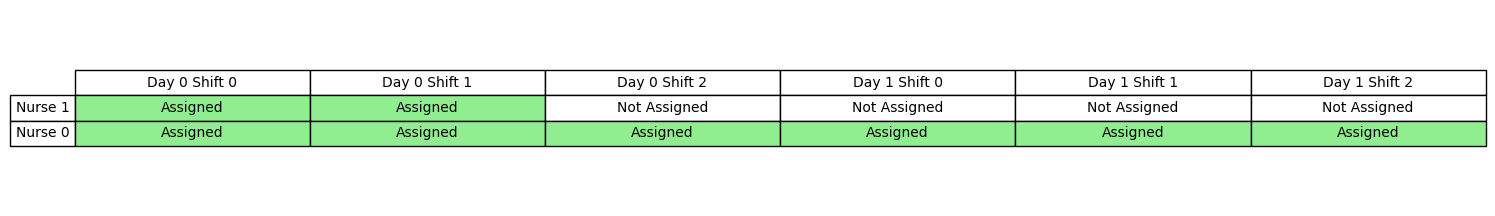

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,0,1])]

Learned 3 constraints in 9 queries.
C_L:  3
B:  0
Number of queries:  9
Top level Queries:  7
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[0,1,1] in GrowAcq
size of B in growacq:  18

GrowAcq: calling inner_algorithm for 4/12 variables
Size of CL:  3
Size of B:  18
Number of queries:  9
MQuAcq-2 Queries:  7
FindScope Queries:  0
FindC Queries:  2
Query9: is this a solution?


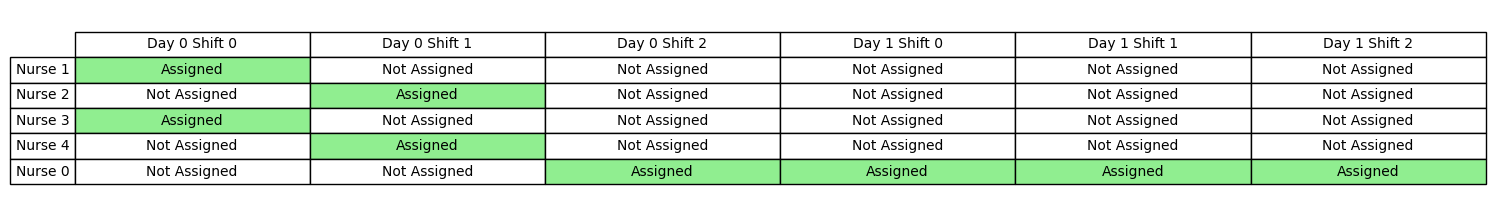

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) == (shifts[0,0,0]), (shifts[0,1,1]) == (shifts[0,1,0]), (shifts[0,1,1]) == (shifts[0,0,1]), (shifts[0,1,1]) < (shifts[0,0,0]), (shifts[0,1,1]) < (shifts[0,1,0]), (shifts[0,1,1]) < (shifts[0,0,1]), (shifts[0,1,1]) <= (shifts[0,0,0]), (shifts[0,1,1]) <= (shifts[0,1,0]), (shifts[0,1,1]) <= (shifts[0,0,1])]
Size of CL:  3
Size of B:  9
Number of queries:  10
MQuAcq-2 Queries:  8
FindScope Queries:  0
FindC Queries:  2
Query10: is this a solution?


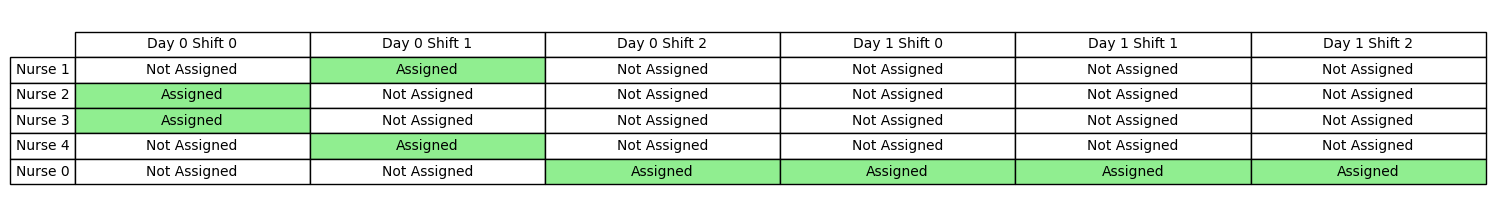

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[0,0,1]), (shifts[0,1,1]) >= (shifts[0,0,0]), (shifts[0,1,1]) >= (shifts[0,0,1]), (shifts[0,1,1]) >= (shifts[0,1,0]), (shifts[0,1,1]) > (shifts[0,1,0]), (shifts[0,1,1]) > (shifts[0,0,0])]
Size of CL:  3
Size of B:  3
Number of queries:  11
MQuAcq-2 Queries:  9
FindScope Queries:  0
FindC Queries:  2
Query11: is this a solution?


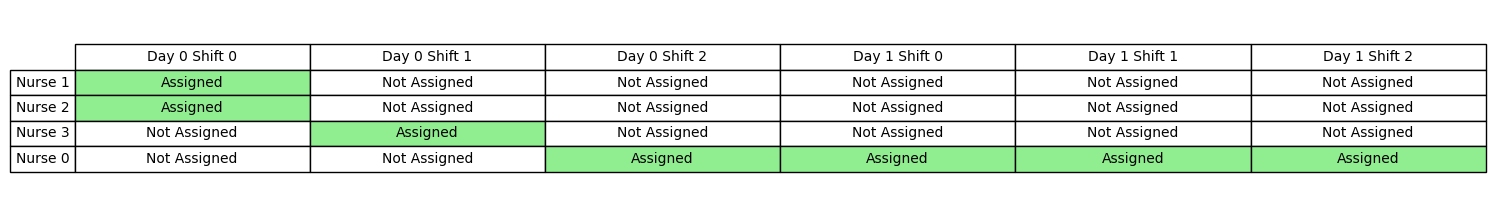

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,1,0])]
Size of CL:  4
Size of B:  2
Number of queries:  12
MQuAcq-2 Queries:  10
FindScope Queries:  0
FindC Queries:  2
Query12: is this a solution?


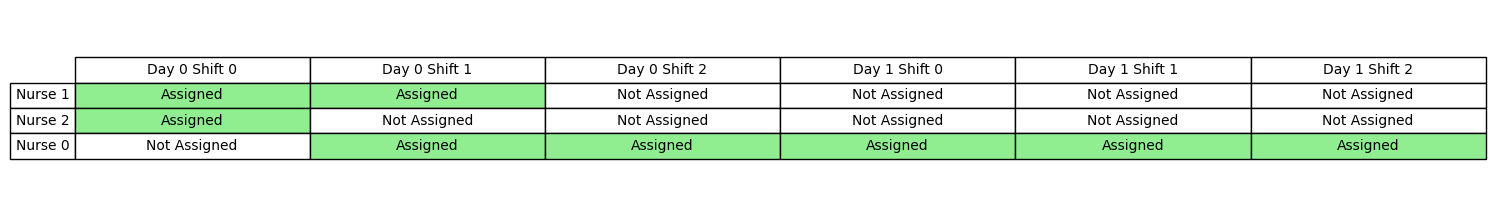

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,0,0])]
Size of CL:  5
Size of B:  1
Number of queries:  13
MQuAcq-2 Queries:  11
FindScope Queries:  0
FindC Queries:  2
Query13: is this a solution?


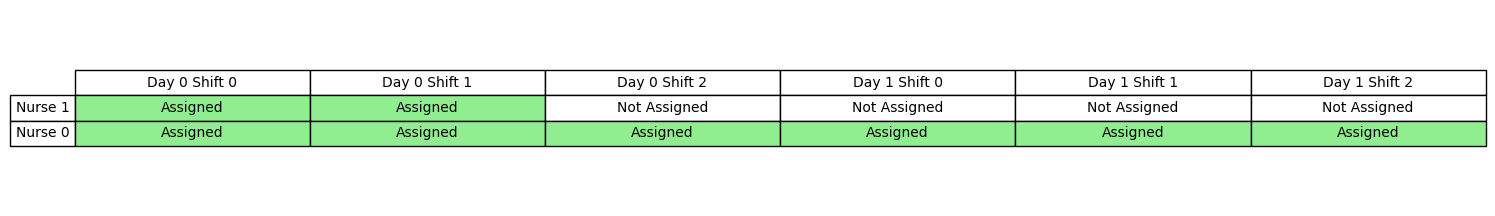

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,0,1])]

Learned 6 constraints in 14 queries.
C_L:  6
B:  0
Number of queries:  14
Top level Queries:  12
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[0,2,0] in GrowAcq
size of B in growacq:  24

GrowAcq: calling inner_algorithm for 5/12 variables
Size of CL:  6
Size of B:  24
Number of queries:  14
MQuAcq-2 Queries:  12
FindScope Queries:  0
FindC Queries:  2
Query14: is this a solution?


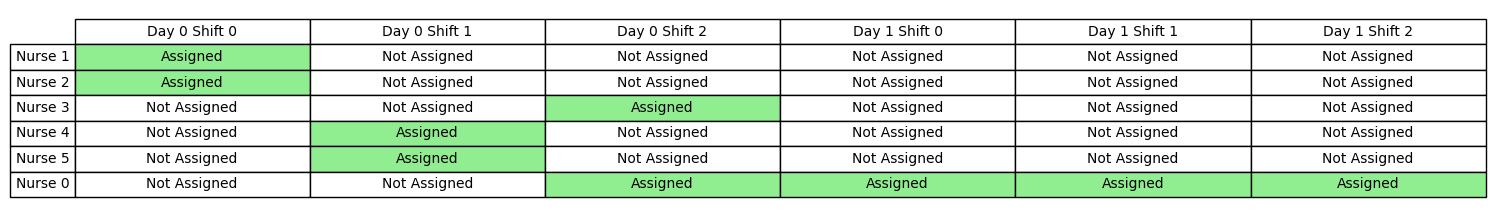

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) == (shifts[0,0,0]), (shifts[0,2,0]) == (shifts[0,1,1]), (shifts[0,2,0]) == (shifts[0,1,0]), (shifts[0,2,0]) == (shifts[0,0,1]), (shifts[0,2,0]) < (shifts[0,0,0]), (shifts[0,2,0]) < (shifts[0,0,1]), (shifts[0,2,0]) > (shifts[0,1,1]), (shifts[0,2,0]) > (shifts[0,1,0]), (shifts[0,2,0]) >= (shifts[0,1,1]), (shifts[0,2,0]) >= (shifts[0,1,0]), (shifts[0,2,0]) <= (shifts[0,0,0]), (shifts[0,2,0]) <= (shifts[0,0,1])]
Size of CL:  6
Size of B:  12
Number of queries:  15
MQuAcq-2 Queries:  13
FindScope Queries:  0
FindC Queries:  2
Query15: is this a solution?


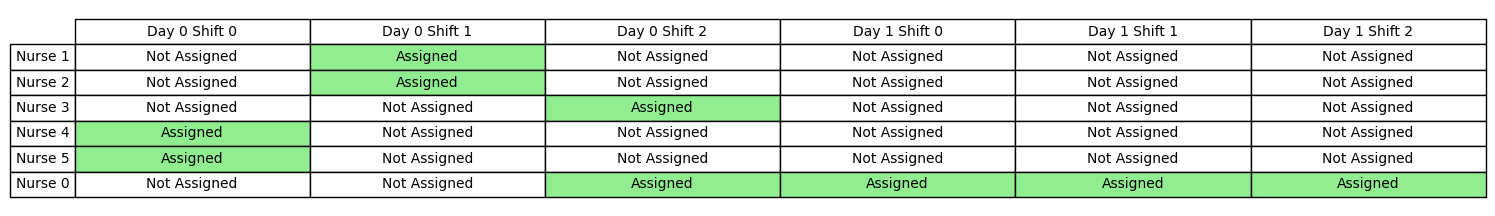

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) > (shifts[0,0,0]), (shifts[0,2,0]) >= (shifts[0,0,0]), (shifts[0,2,0]) <= (shifts[0,1,0]), (shifts[0,2,0]) < (shifts[0,1,0]), (shifts[0,2,0]) > (shifts[0,0,1]), (shifts[0,2,0]) <= (shifts[0,1,1]), (shifts[0,2,0]) < (shifts[0,1,1]), (shifts[0,2,0]) >= (shifts[0,0,1])]
Size of CL:  6
Size of B:  4
Number of queries:  16
MQuAcq-2 Queries:  14
FindScope Queries:  0
FindC Queries:  2
Query16: is this a solution?


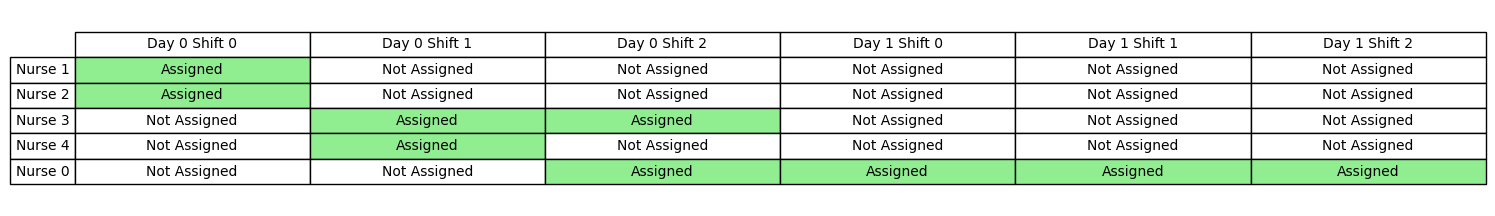

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,1,0])]
Size of CL:  7
Size of B:  3
Number of queries:  17
MQuAcq-2 Queries:  15
FindScope Queries:  0
FindC Queries:  2
Query17: is this a solution?


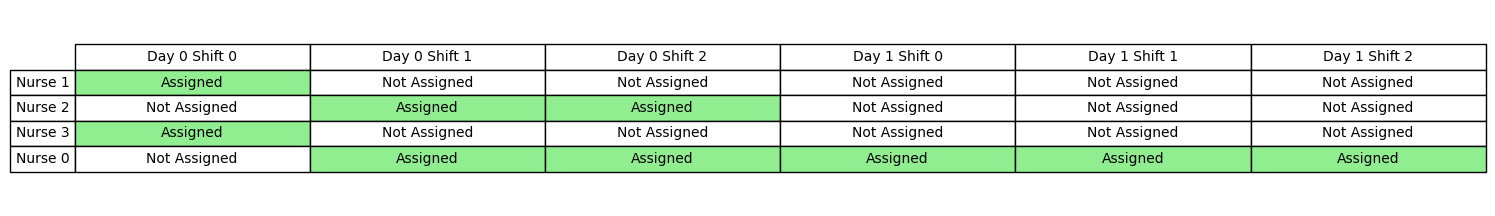

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,1,1])]
Size of CL:  8
Size of B:  2
Number of queries:  18
MQuAcq-2 Queries:  16
FindScope Queries:  0
FindC Queries:  2
Query18: is this a solution?


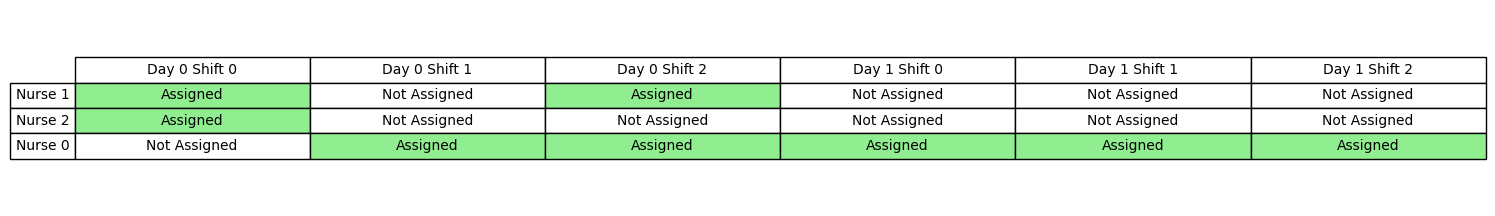

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,0,0])]
Size of CL:  9
Size of B:  1
Number of queries:  19
MQuAcq-2 Queries:  17
FindScope Queries:  0
FindC Queries:  2
Query19: is this a solution?


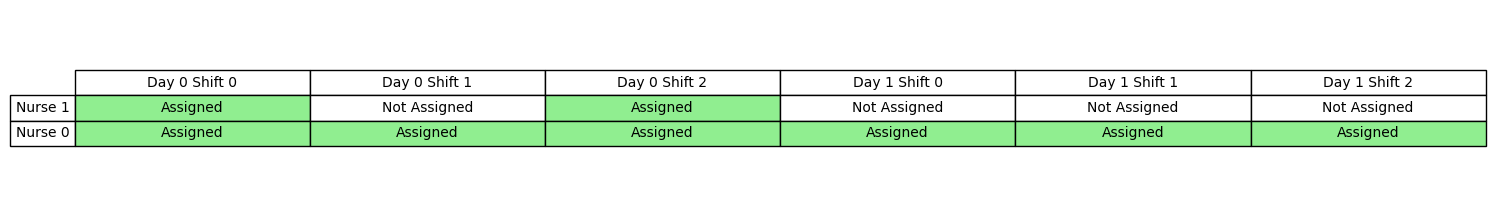

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,0,1])]

Learned 10 constraints in 20 queries.
C_L:  10
B:  0
Number of queries:  20
Top level Queries:  18
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[0,2,1] in GrowAcq
size of B in growacq:  30

GrowAcq: calling inner_algorithm for 6/12 variables
Size of CL:  10
Size of B:  30
Number of queries:  20
MQuAcq-2 Queries:  18
FindScope Queries:  0
FindC Queries:  2
Query20: is this a solution?


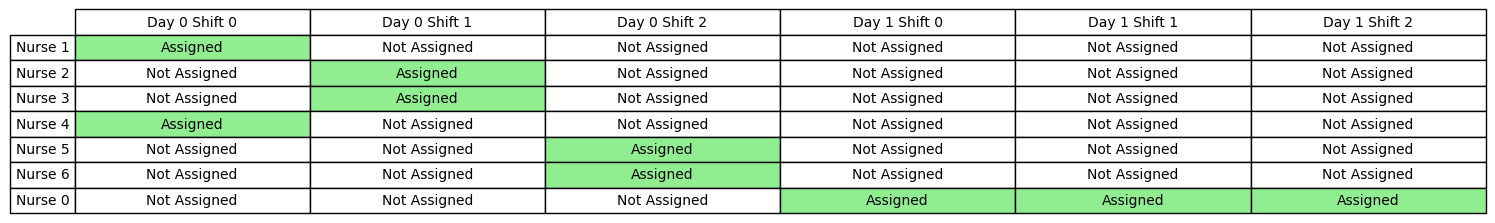

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) == (shifts[0,1,0]), (shifts[0,2,1]) == (shifts[0,2,0]), (shifts[0,2,1]) == (shifts[0,0,1]), (shifts[0,2,1]) == (shifts[0,0,0]), (shifts[0,2,1]) == (shifts[0,1,1]), (shifts[0,2,1]) < (shifts[0,1,0]), (shifts[0,2,1]) < (shifts[0,2,0]), (shifts[0,2,1]) < (shifts[0,0,1]), (shifts[0,2,1]) < (shifts[0,0,0]), (shifts[0,2,1]) < (shifts[0,1,1]), (shifts[0,2,1]) <= (shifts[0,1,0]), (shifts[0,2,1]) <= (shifts[0,2,0]), (shifts[0,2,1]) <= (shifts[0,0,1]), (shifts[0,2,1]) <= (shifts[0,0,0]), (shifts[0,2,1]) <= (shifts[0,1,1])]
Size of CL:  10
Size of B:  15
Number of queries:  21
MQuAcq-2 Queries:  19
FindScope Queries:  0
FindC Queries:  2
Query21: is this a solution?


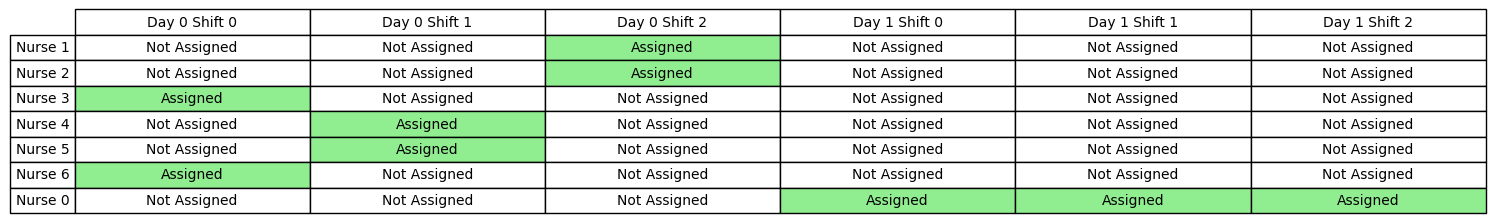

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) >= (shifts[0,1,0]), (shifts[0,2,1]) > (shifts[0,0,1]), (shifts[0,2,1]) >= (shifts[0,2,0]), (shifts[0,2,1]) > (shifts[0,2,0]), (shifts[0,2,1]) >= (shifts[0,1,1]), (shifts[0,2,1]) >= (shifts[0,0,1]), (shifts[0,2,1]) > (shifts[0,1,1]), (shifts[0,2,1]) > (shifts[0,0,0]), (shifts[0,2,1]) >= (shifts[0,0,0]), (shifts[0,2,1]) > (shifts[0,1,0])]
Size of CL:  10
Size of B:  5
Number of queries:  22
MQuAcq-2 Queries:  20
FindScope Queries:  0
FindC Queries:  2
Query22: is this a solution?


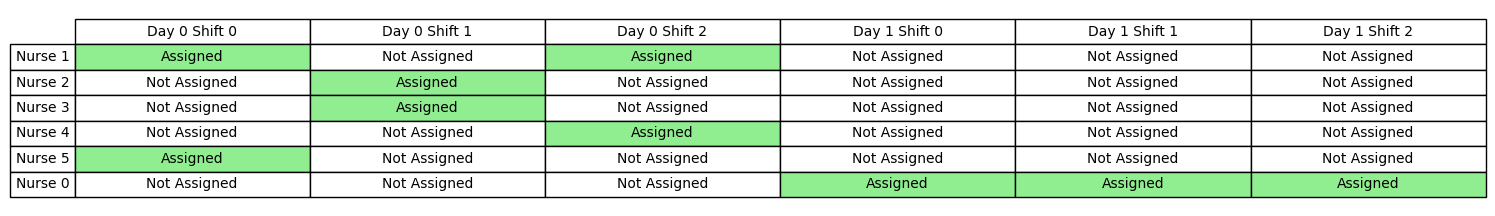

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[0,0,0])]
Size of CL:  11
Size of B:  4
Number of queries:  23
MQuAcq-2 Queries:  21
FindScope Queries:  0
FindC Queries:  2
Query23: is this a solution?


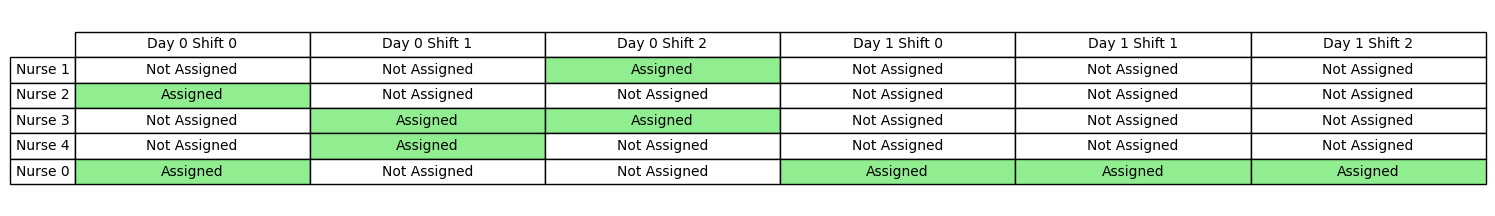

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[0,1,0])]
Size of CL:  12
Size of B:  3
Number of queries:  24
MQuAcq-2 Queries:  22
FindScope Queries:  0
FindC Queries:  2
Query24: is this a solution?


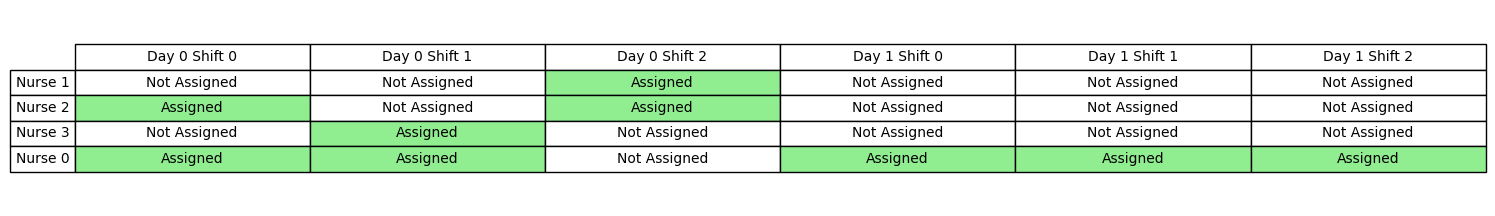

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[0,0,1])]
Size of CL:  13
Size of B:  2
Number of queries:  25
MQuAcq-2 Queries:  23
FindScope Queries:  0
FindC Queries:  2
Query25: is this a solution?


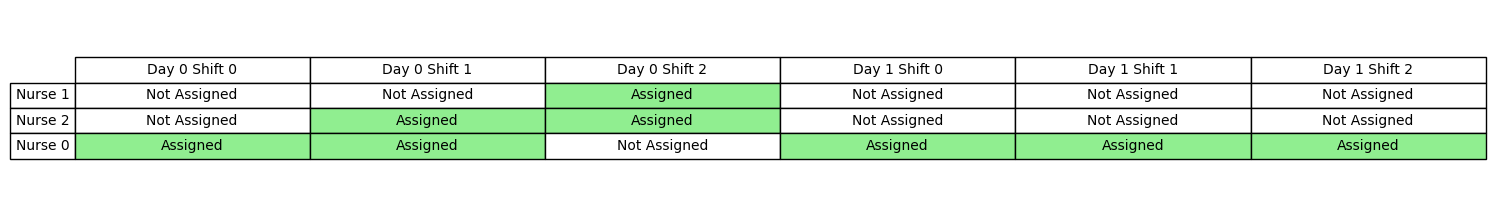

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[0,1,1])]
Size of CL:  14
Size of B:  1
Number of queries:  26
MQuAcq-2 Queries:  24
FindScope Queries:  0
FindC Queries:  2
Query26: is this a solution?


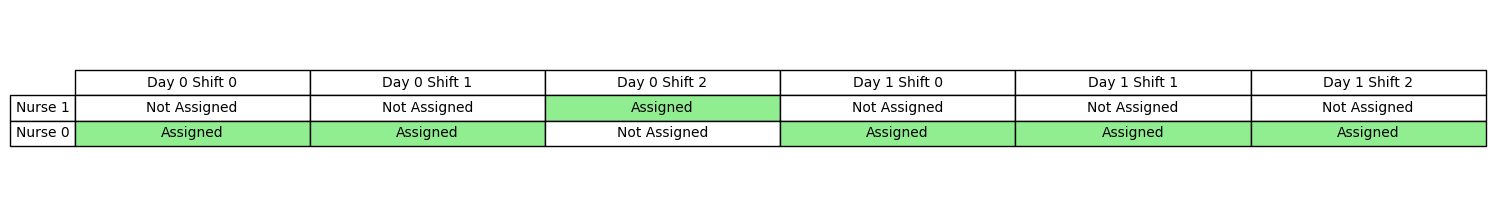

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[0,2,0])]

Learned 15 constraints in 27 queries.
C_L:  15
B:  0
Number of queries:  27
Top level Queries:  25
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,0,0] in GrowAcq
size of B in growacq:  36

GrowAcq: calling inner_algorithm for 7/12 variables
Size of CL:  15
Size of B:  36
Number of queries:  27
MQuAcq-2 Queries:  25
FindScope Queries:  0
FindC Queries:  2
Query27: is this a solution?


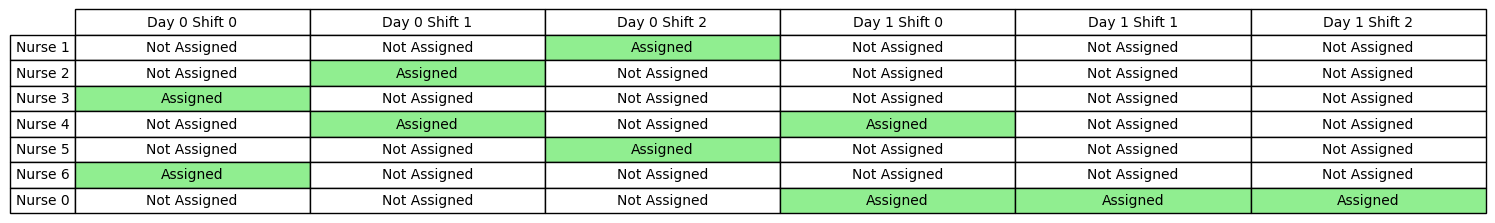

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) == (shifts[0,1,0]), (shifts[1,0,0]) == (shifts[0,2,0]), (shifts[1,0,0]) == (shifts[0,2,1]), (shifts[1,0,0]) == (shifts[0,0,1]), (shifts[1,0,0]) == (shifts[0,0,0]), (shifts[1,0,0]) != (shifts[0,1,1]), (shifts[1,0,0]) < (shifts[0,1,0]), (shifts[1,0,0]) < (shifts[0,2,0]), (shifts[1,0,0]) < (shifts[0,0,0]), (shifts[1,0,0]) < (shifts[0,1,1]), (shifts[1,0,0]) > (shifts[0,2,1]), (shifts[1,0,0]) > (shifts[0,0,1]), (shifts[1,0,0]) > (shifts[0,1,1]), (shifts[1,0,0]) >= (shifts[0,2,1]), (shifts[1,0,0]) >= (shifts[0,0,1]), (shifts[1,0,0]) <= (shifts[0,1,0]), (shifts[1,0,0]) <= (shifts[0,2,0]), (shifts[1,0,0]) <= (shifts[0,0,0])]
Size of CL:  15
Size of B:  18
Number of queries:  28
MQuAcq-2 Queries:  26
FindScope Queries:  0
FindC Queries:  2
Query28: is this a solution?


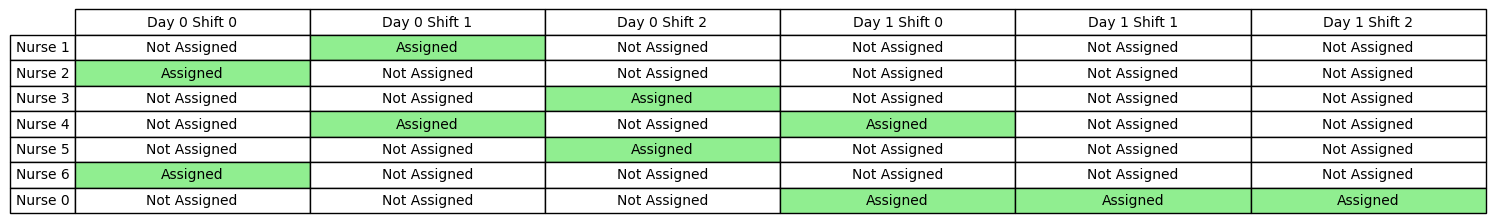

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) > (shifts[0,0,0]), (shifts[1,0,0]) >= (shifts[0,0,0]), (shifts[1,0,0]) <= (shifts[0,2,1]), (shifts[1,0,0]) < (shifts[0,0,1]), (shifts[1,0,0]) < (shifts[0,2,1]), (shifts[1,0,0]) <= (shifts[0,0,1]), (shifts[1,0,0]) <= (shifts[0,1,1]), (shifts[1,0,0]) > (shifts[0,1,0]), (shifts[1,0,0]) >= (shifts[0,2,0]), (shifts[1,0,0]) == (shifts[0,1,1]), (shifts[1,0,0]) > (shifts[0,2,0]), (shifts[1,0,0]) != (shifts[0,1,0])]
Size of CL:  15
Size of B:  6
Number of queries:  29
MQuAcq-2 Queries:  27
FindScope Queries:  0
FindC Queries:  2
Query29: is this a solution?


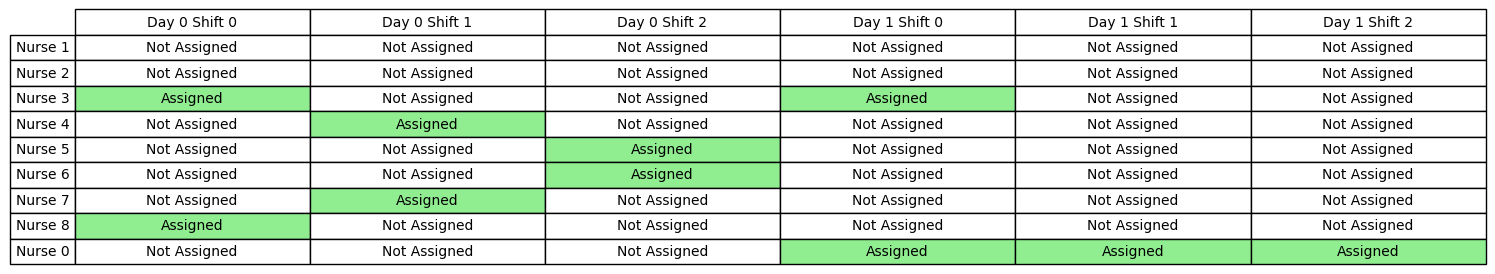

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) != (shifts[0,0,0]), (shifts[1,0,0]) >= (shifts[0,1,0]), (shifts[1,0,0]) >= (shifts[0,1,1])]
Size of CL:  15
Size of B:  3
Number of queries:  30
MQuAcq-2 Queries:  28
FindScope Queries:  0
FindC Queries:  2
Query30: is this a solution?


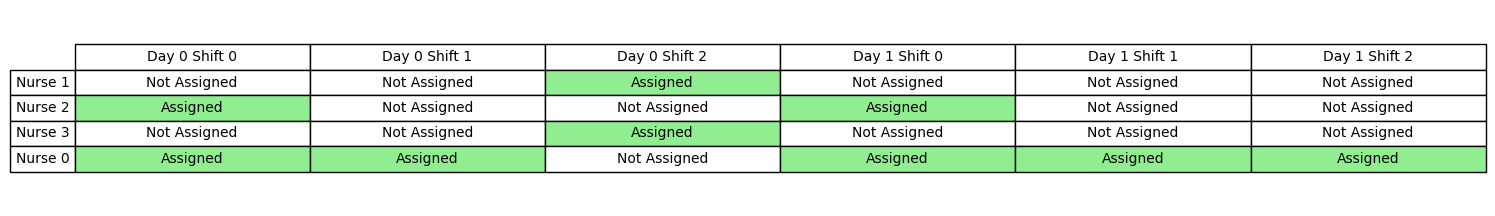

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) != (shifts[0,0,1])]
Size of CL:  15
Size of B:  2
Number of queries:  31
MQuAcq-2 Queries:  29
FindScope Queries:  0
FindC Queries:  2
Query31: is this a solution?


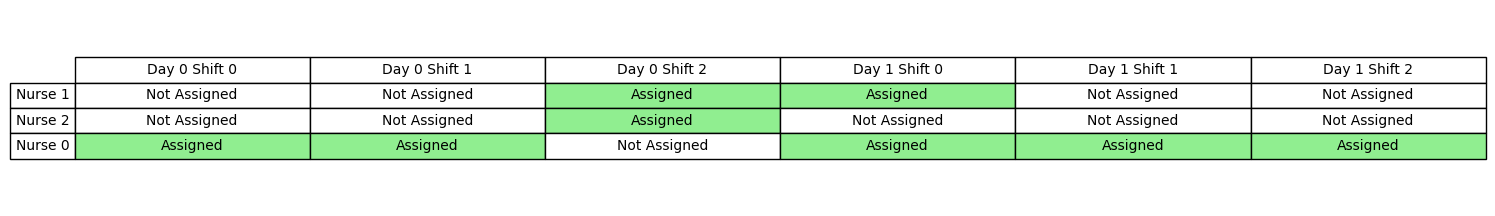

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[0,2,0])]
Size of CL:  16
Size of B:  1
Number of queries:  32
MQuAcq-2 Queries:  30
FindScope Queries:  0
FindC Queries:  2
Query32: is this a solution?


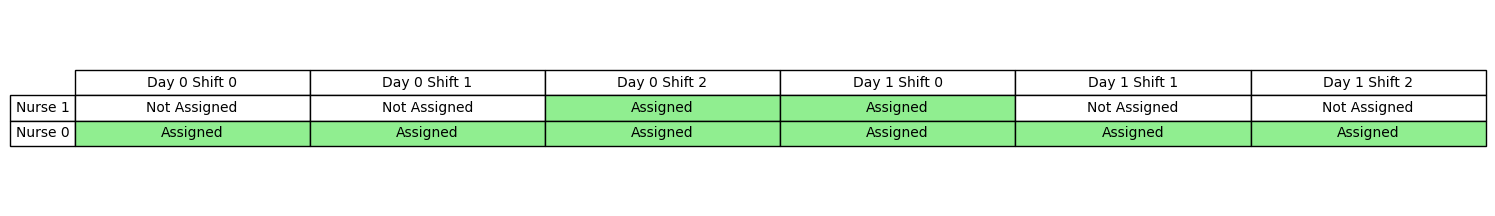

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[0,2,1])]

Learned 17 constraints in 33 queries.
C_L:  17
B:  0
Number of queries:  33
Top level Queries:  31
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,0,1] in GrowAcq
size of B in growacq:  42

GrowAcq: calling inner_algorithm for 8/12 variables
Size of CL:  17
Size of B:  42
Number of queries:  33
MQuAcq-2 Queries:  31
FindScope Queries:  0
FindC Queries:  2
Query33: is this a solution?


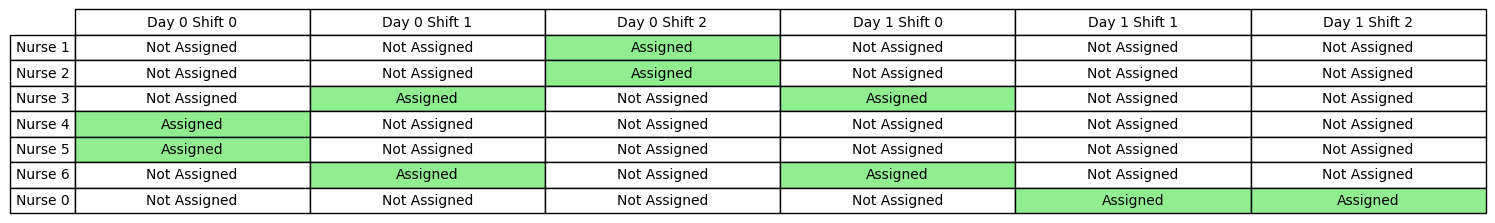

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) == (shifts[0,2,0]), (shifts[1,0,1]) == (shifts[0,2,1]), (shifts[1,0,1]) == (shifts[1,0,0]), (shifts[1,0,1]) == (shifts[0,0,1]), (shifts[1,0,1]) == (shifts[0,0,0]), (shifts[1,0,1]) == (shifts[0,1,1]), (shifts[1,0,1]) != (shifts[0,1,0]), (shifts[1,0,1]) < (shifts[0,1,0]), (shifts[1,0,1]) < (shifts[0,2,0]), (shifts[1,0,1]) < (shifts[0,2,1]), (shifts[1,0,1]) < (shifts[1,0,0]), (shifts[1,0,1]) < (shifts[0,0,1]), (shifts[1,0,1]) < (shifts[0,0,0]), (shifts[1,0,1]) < (shifts[0,1,1]), (shifts[1,0,1]) > (shifts[0,1,0]), (shifts[1,0,1]) <= (shifts[0,2,0]), (shifts[1,0,1]) <= (shifts[0,2,1]), (shifts[1,0,1]) <= (shifts[1,0,0]), (shifts[1,0,1]) <= (shifts[0,0,1]), (shifts[1,0,1]) <= (shifts[0,0,0]), (shifts[1,0,1]) <= (shifts[0,1,1])]
Size of CL:  17
Size of B:  21
Number of queries:  34
MQuAcq-2 Queries:  32
FindScope Queries:  0
FindC Queries:  2
Query34: is this a solution?


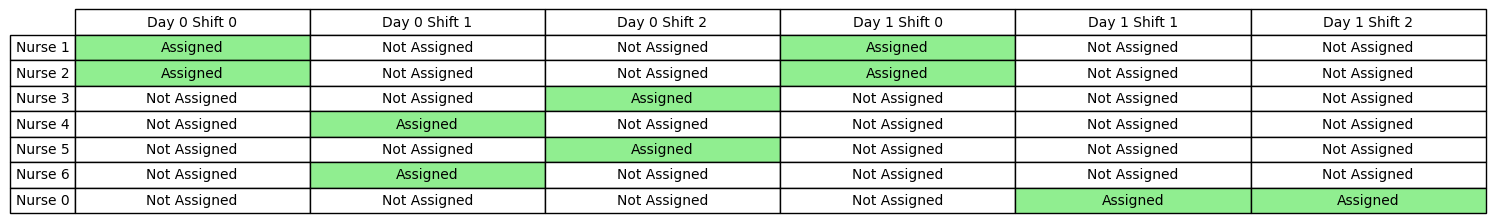

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) > (shifts[0,2,0]), (shifts[1,0,1]) >= (shifts[0,2,1]), (shifts[1,0,1]) > (shifts[0,2,1]), (shifts[1,0,1]) >= (shifts[0,1,1]), (shifts[1,0,1]) >= (shifts[0,0,0]), (shifts[1,0,1]) > (shifts[1,0,0]), (shifts[1,0,1]) != (shifts[0,0,1]), (shifts[1,0,1]) == (shifts[0,1,0]), (shifts[1,0,1]) >= (shifts[0,1,0]), (shifts[1,0,1]) > (shifts[0,0,1]), (shifts[1,0,1]) > (shifts[0,0,0]), (shifts[1,0,1]) >= (shifts[0,2,0]), (shifts[1,0,1]) >= (shifts[1,0,0]), (shifts[1,0,1]) > (shifts[0,1,1])]
Size of CL:  17
Size of B:  7
Number of queries:  35
MQuAcq-2 Queries:  33
FindScope Queries:  0
FindC Queries:  2
Query35: is this a solution?


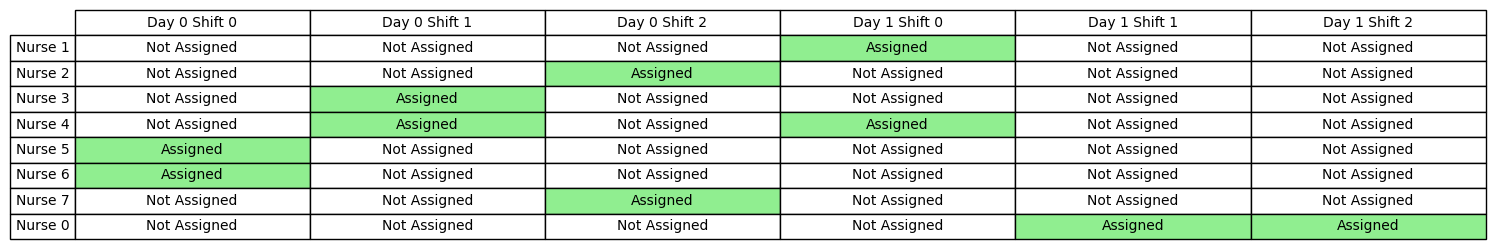

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) <= (shifts[0,1,0]), (shifts[1,0,1]) >= (shifts[0,0,1]), (shifts[1,0,1]) != (shifts[0,1,1])]
Size of CL:  17
Size of B:  4
Number of queries:  36
MQuAcq-2 Queries:  34
FindScope Queries:  0
FindC Queries:  2
Query36: is this a solution?


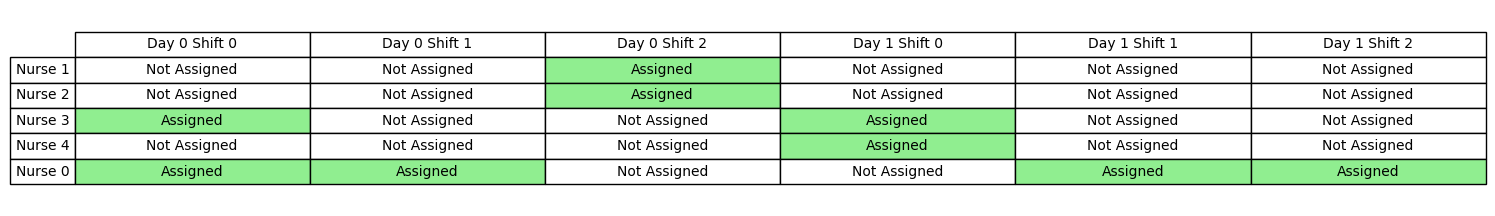

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) != (shifts[0,0,0])]
Size of CL:  17
Size of B:  3
Number of queries:  37
MQuAcq-2 Queries:  35
FindScope Queries:  0
FindC Queries:  2
Query37: is this a solution?


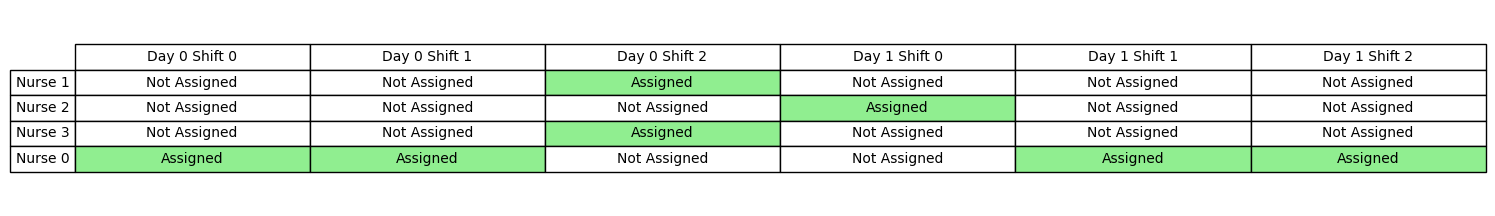

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,0,0])]
Size of CL:  18
Size of B:  2
Number of queries:  38
MQuAcq-2 Queries:  36
FindScope Queries:  0
FindC Queries:  2
Query38: is this a solution?


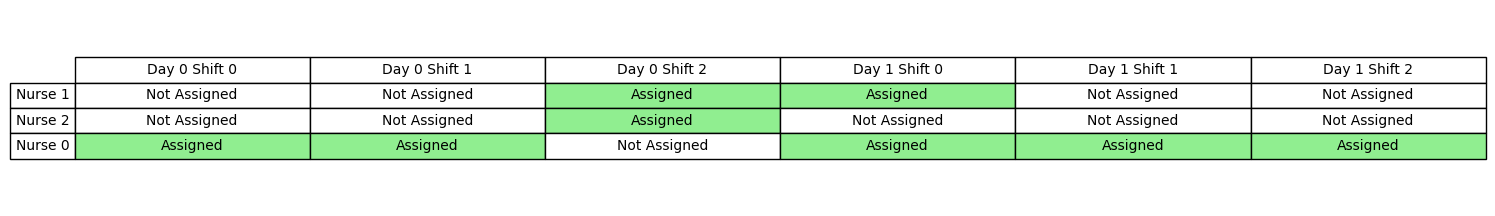

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[0,2,0])]
Size of CL:  19
Size of B:  1
Number of queries:  39
MQuAcq-2 Queries:  37
FindScope Queries:  0
FindC Queries:  2
Query39: is this a solution?


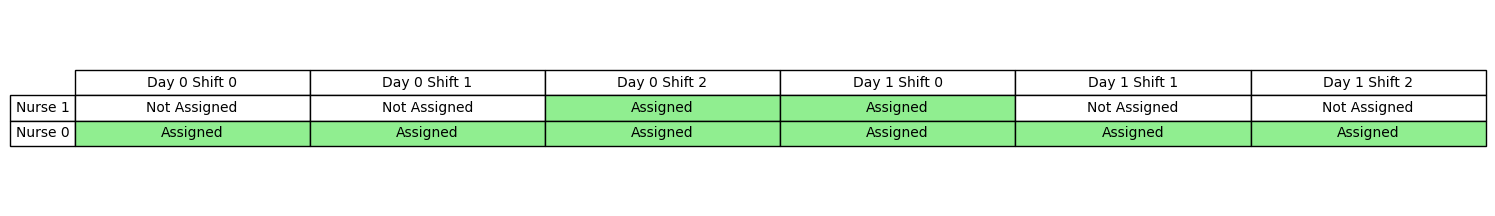

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[0,2,1])]

Learned 20 constraints in 40 queries.
C_L:  20
B:  0
Number of queries:  40
Top level Queries:  38
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,1,0] in GrowAcq
size of B in growacq:  48

GrowAcq: calling inner_algorithm for 9/12 variables
Size of CL:  20
Size of B:  48
Number of queries:  40
MQuAcq-2 Queries:  38
FindScope Queries:  0
FindC Queries:  2
Query40: is this a solution?


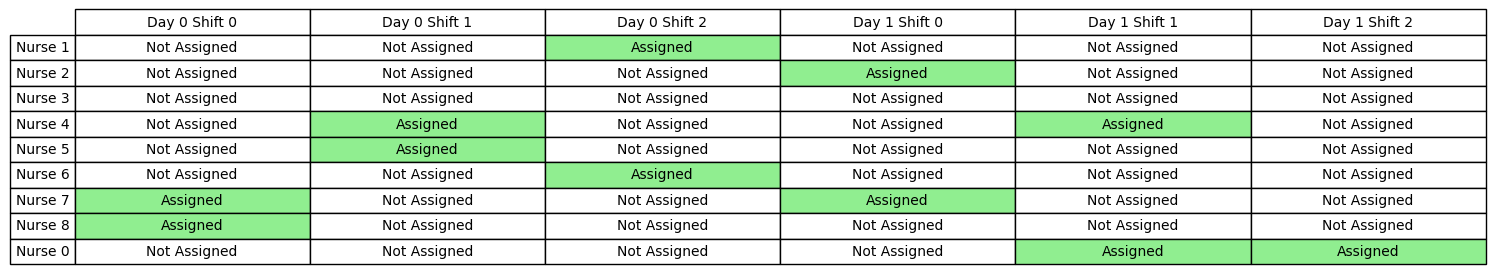

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) == (shifts[1,0,1]), (shifts[1,1,0]) == (shifts[0,1,0]), (shifts[1,1,0]) == (shifts[0,2,0]), (shifts[1,1,0]) == (shifts[0,2,1]), (shifts[1,1,0]) == (shifts[1,0,0]), (shifts[1,1,0]) == (shifts[0,0,1]), (shifts[1,1,0]) == (shifts[0,0,0]), (shifts[1,1,0]) != (shifts[0,1,1]), (shifts[1,1,0]) < (shifts[1,0,1]), (shifts[1,1,0]) < (shifts[0,2,1]), (shifts[1,1,0]) < (shifts[0,1,1]), (shifts[1,1,0]) > (shifts[0,1,0]), (shifts[1,1,0]) > (shifts[0,2,0]), (shifts[1,1,0]) > (shifts[1,0,0]), (shifts[1,1,0]) > (shifts[0,0,1]), (shifts[1,1,0]) > (shifts[0,0,0]), (shifts[1,1,0]) > (shifts[0,1,1]), (shifts[1,1,0]) >= (shifts[0,1,0]), (shifts[1,1,0]) >= (shifts[0,2,0]), (shifts[1,1,0]) >= (shifts[1,0,0]), (shifts[1,1,0]) >= (shifts[0,0,1]), (shifts[1,1,0]) >= (shifts[0,0,0]), (shifts[1,1,0]) <= (shifts[1,0,1]), (shifts[1,1,0]) <= (shifts[0,2,1])]
Size of CL:  20
Size of B:  24
Number of queries:  41
MQuAcq-2 Queries:  39
FindScope

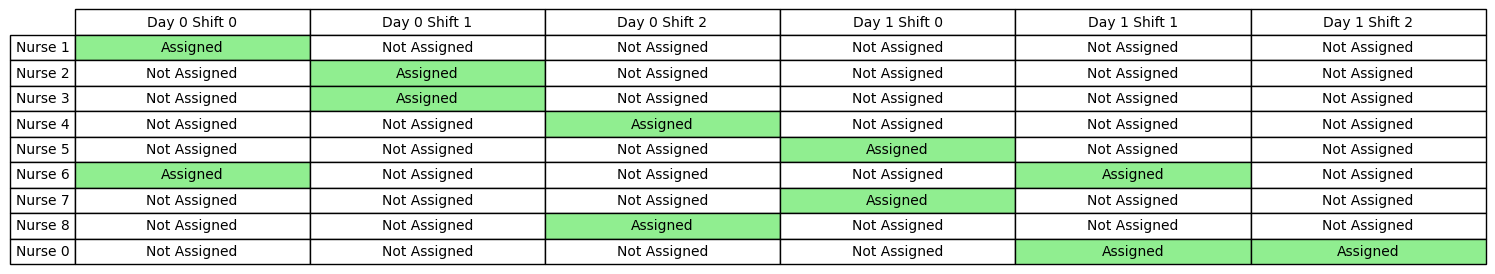

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) > (shifts[1,0,1]), (shifts[1,1,0]) >= (shifts[1,0,1]), (shifts[1,1,0]) <= (shifts[1,0,0]), (shifts[1,1,0]) <= (shifts[0,1,1]), (shifts[1,1,0]) <= (shifts[0,1,0]), (shifts[1,1,0]) == (shifts[0,1,1]), (shifts[1,1,0]) < (shifts[0,2,0]), (shifts[1,1,0]) != (shifts[0,0,1]), (shifts[1,1,0]) < (shifts[1,0,0]), (shifts[1,1,0]) < (shifts[0,0,0]), (shifts[1,1,0]) < (shifts[0,0,1]), (shifts[1,1,0]) <= (shifts[0,0,0]), (shifts[1,1,0]) < (shifts[0,1,0]), (shifts[1,1,0]) >= (shifts[0,2,1]), (shifts[1,1,0]) > (shifts[0,2,1]), (shifts[1,1,0]) <= (shifts[0,2,0])]
Size of CL:  20
Size of B:  8
Number of queries:  42
MQuAcq-2 Queries:  40
FindScope Queries:  0
FindC Queries:  2
Query42: is this a solution?


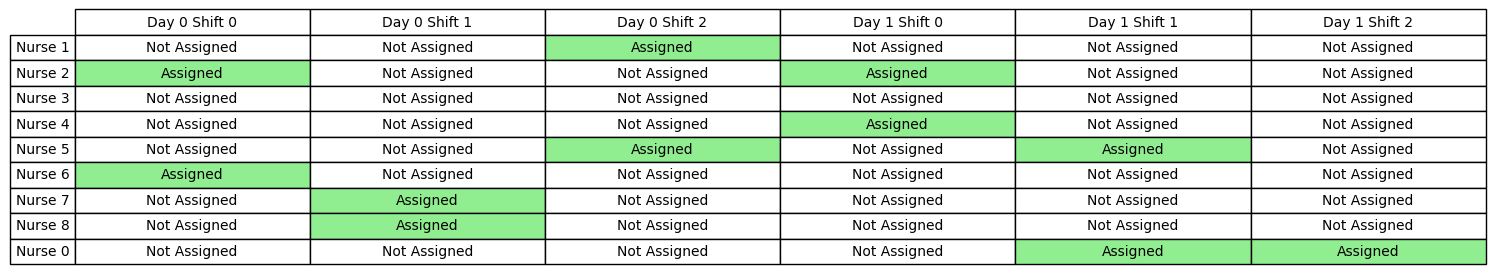

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) != (shifts[0,2,0]), (shifts[1,1,0]) <= (shifts[0,0,1]), (shifts[1,1,0]) >= (shifts[0,1,1])]
Size of CL:  20
Size of B:  5
Number of queries:  43
MQuAcq-2 Queries:  41
FindScope Queries:  0
FindC Queries:  2
Query43: is this a solution?


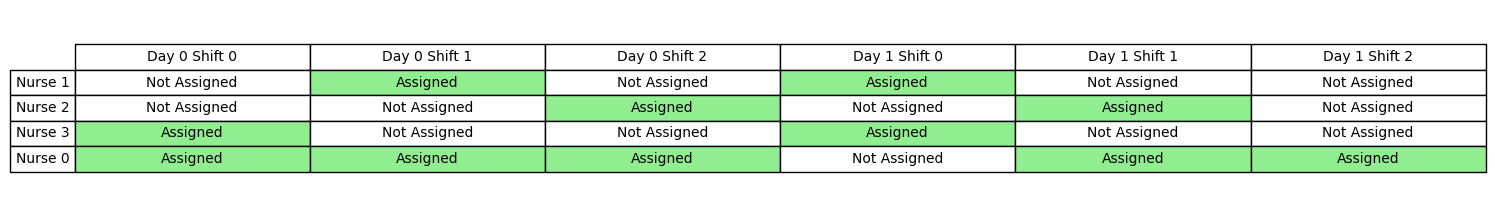

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) != (shifts[0,2,1])]
Size of CL:  20
Size of B:  4
Number of queries:  44
MQuAcq-2 Queries:  42
FindScope Queries:  0
FindC Queries:  2
Query44: is this a solution?


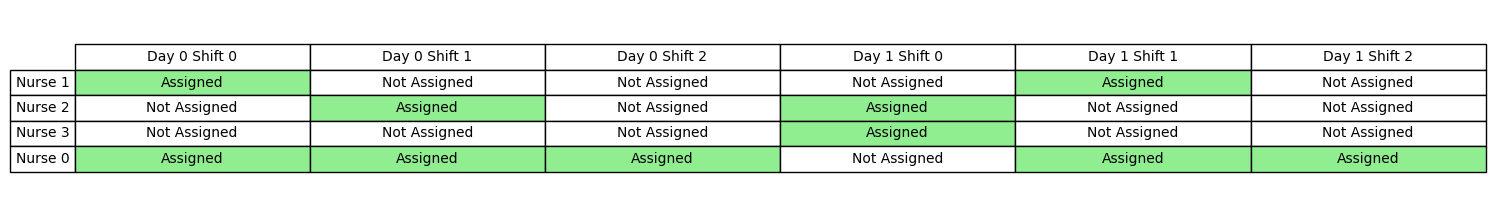

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) != (shifts[0,0,0])]
Size of CL:  20
Size of B:  3
Number of queries:  45
MQuAcq-2 Queries:  43
FindScope Queries:  0
FindC Queries:  2
Query45: is this a solution?


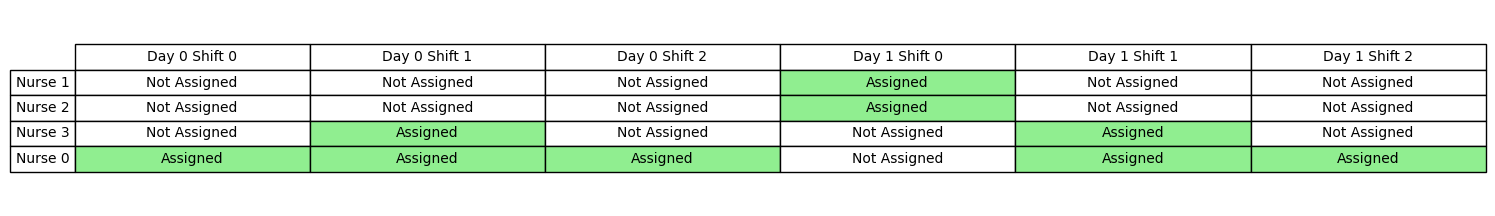

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) != (shifts[0,1,0])]
Size of CL:  20
Size of B:  2
Number of queries:  46
MQuAcq-2 Queries:  44
FindScope Queries:  0
FindC Queries:  2
Query46: is this a solution?


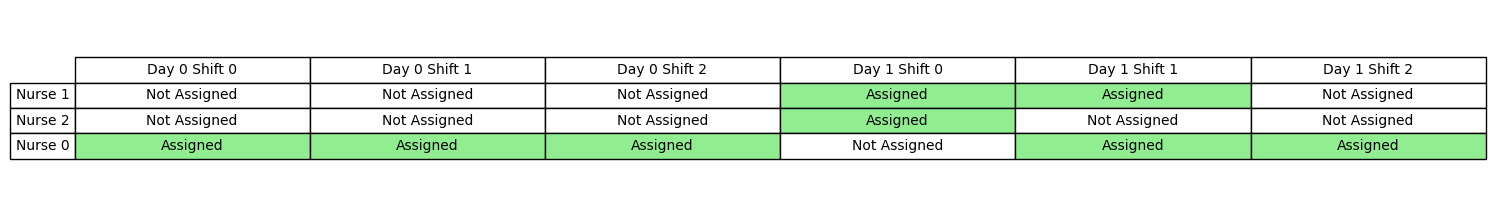

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,0,0])]
Size of CL:  21
Size of B:  1
Number of queries:  47
MQuAcq-2 Queries:  45
FindScope Queries:  0
FindC Queries:  2
Query47: is this a solution?


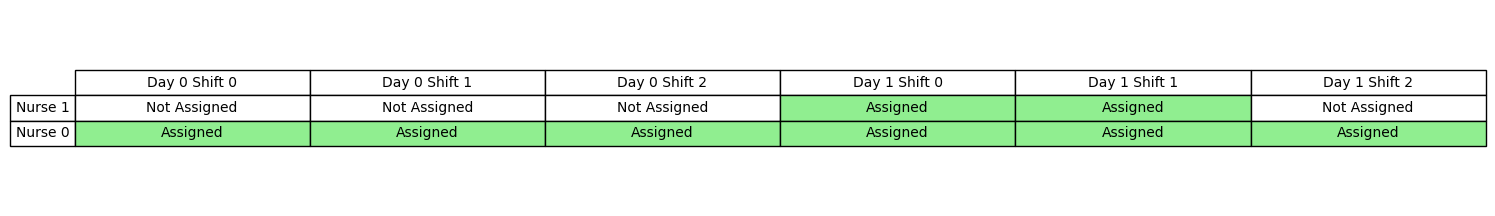

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,0,1])]

Learned 22 constraints in 48 queries.
C_L:  22
B:  0
Number of queries:  48
Top level Queries:  46
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,1,1] in GrowAcq
size of B in growacq:  54

GrowAcq: calling inner_algorithm for 10/12 variables
Size of CL:  22
Size of B:  54
Number of queries:  48
MQuAcq-2 Queries:  46
FindScope Queries:  0
FindC Queries:  2
Query48: is this a solution?


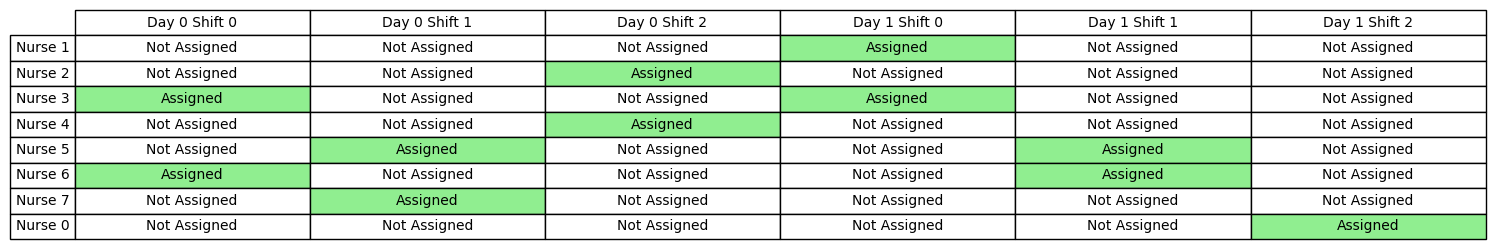

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) == (shifts[1,0,1]), (shifts[1,1,1]) == (shifts[1,1,0]), (shifts[1,1,1]) == (shifts[0,2,0]), (shifts[1,1,1]) == (shifts[0,2,1]), (shifts[1,1,1]) == (shifts[1,0,0]), (shifts[1,1,1]) == (shifts[0,0,1]), (shifts[1,1,1]) == (shifts[0,0,0]), (shifts[1,1,1]) == (shifts[0,1,1]), (shifts[1,1,1]) != (shifts[0,1,0]), (shifts[1,1,1]) < (shifts[1,0,1]), (shifts[1,1,1]) < (shifts[0,1,0]), (shifts[1,1,1]) < (shifts[0,2,0]), (shifts[1,1,1]) < (shifts[0,2,1]), (shifts[1,1,1]) < (shifts[1,0,0]), (shifts[1,1,1]) < (shifts[0,0,1]), (shifts[1,1,1]) > (shifts[0,1,0]), (shifts[1,1,1]) > (shifts[1,1,0]), (shifts[1,1,1]) > (shifts[0,0,0]), (shifts[1,1,1]) > (shifts[0,1,1]), (shifts[1,1,1]) >= (shifts[1,1,0]), (shifts[1,1,1]) >= (shifts[0,0,0]), (shifts[1,1,1]) >= (shifts[0,1,1]), (shifts[1,1,1]) <= (shifts[1,0,1]), (shifts[1,1,1]) <= (shifts[0,2,0]), (shifts[1,1,1]) <= (shifts[0,2,1]), (shifts[1,1,1]) <= (shifts[1,0,0]), (shifts[1,1,1]

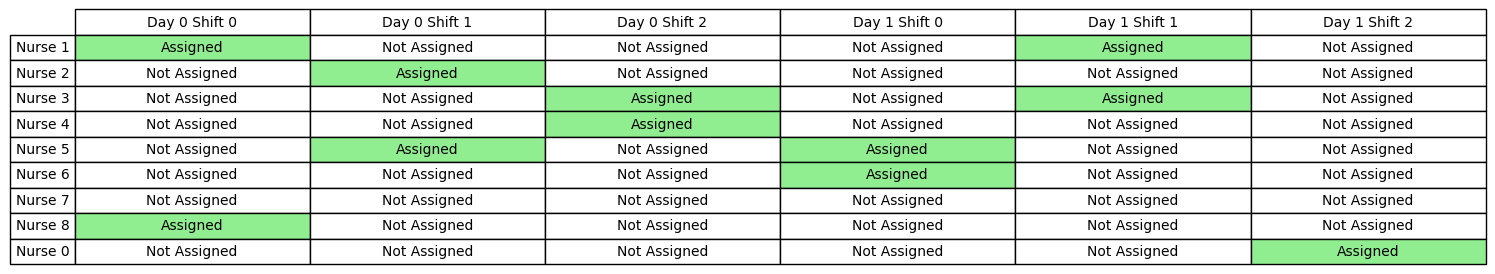

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) >= (shifts[0,0,1]), (shifts[1,1,1]) <= (shifts[1,1,0]), (shifts[1,1,1]) == (shifts[0,1,0]), (shifts[1,1,1]) != (shifts[0,2,0]), (shifts[1,1,1]) > (shifts[0,2,1]), (shifts[1,1,1]) <= (shifts[0,1,1]), (shifts[1,1,1]) >= (shifts[1,0,0]), (shifts[1,1,1]) >= (shifts[0,1,0]), (shifts[1,1,1]) < (shifts[0,1,1]), (shifts[1,1,1]) >= (shifts[0,2,1]), (shifts[1,1,1]) < (shifts[0,0,0]), (shifts[1,1,1]) > (shifts[0,2,0]), (shifts[1,1,1]) < (shifts[1,1,0]), (shifts[1,1,1]) > (shifts[1,0,0]), (shifts[1,1,1]) >= (shifts[1,0,1]), (shifts[1,1,1]) > (shifts[0,0,1]), (shifts[1,1,1]) > (shifts[1,0,1]), (shifts[1,1,1]) <= (shifts[0,0,0])]
Size of CL:  22
Size of B:  9
Number of queries:  50
MQuAcq-2 Queries:  48
FindScope Queries:  0
FindC Queries:  2
Query50: is this a solution?


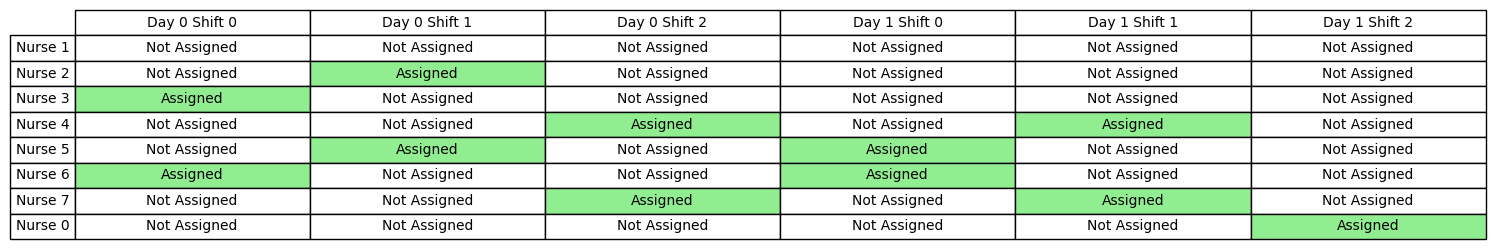

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) >= (shifts[0,2,0]), (shifts[1,1,1]) <= (shifts[0,1,0]), (shifts[1,1,1]) != (shifts[0,2,1])]
Size of CL:  22
Size of B:  6
Number of queries:  51
MQuAcq-2 Queries:  49
FindScope Queries:  0
FindC Queries:  2
Query51: is this a solution?


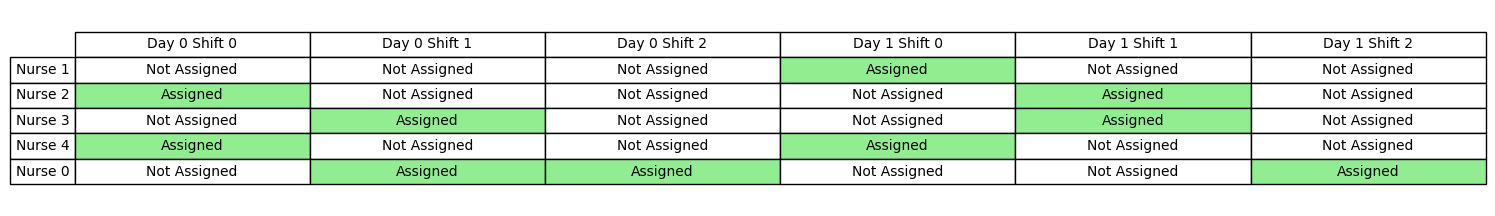

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) != (shifts[0,0,0])]
Size of CL:  22
Size of B:  5
Number of queries:  52
MQuAcq-2 Queries:  50
FindScope Queries:  0
FindC Queries:  2
Query52: is this a solution?


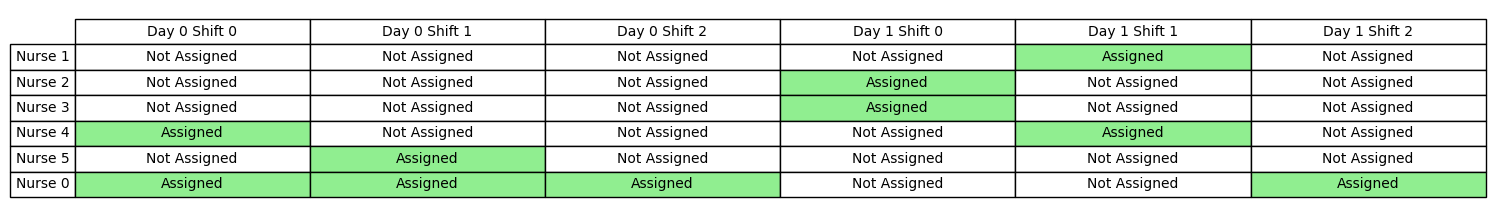

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) != (shifts[0,0,1])]
Size of CL:  22
Size of B:  4
Number of queries:  53
MQuAcq-2 Queries:  51
FindScope Queries:  0
FindC Queries:  2
Query53: is this a solution?


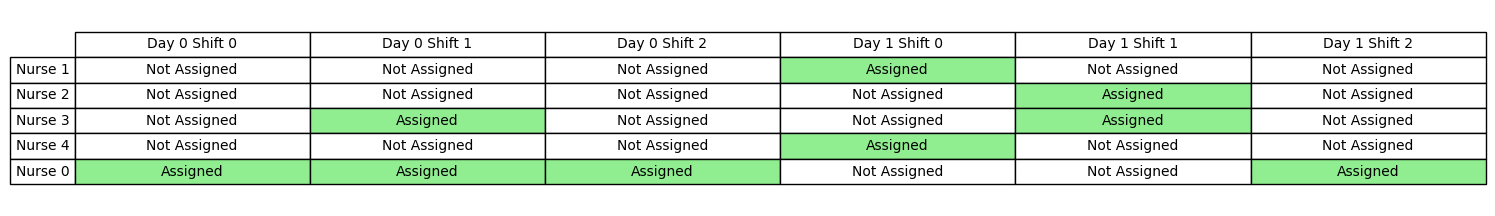

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,1]) != (shifts[0,1,1])]
Size of CL:  22
Size of B:  3
Number of queries:  54
MQuAcq-2 Queries:  52
FindScope Queries:  0
FindC Queries:  2
Query54: is this a solution?


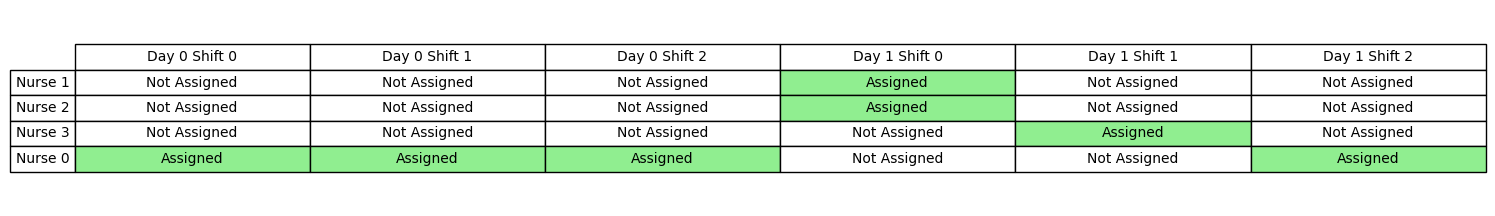

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,1,0])]
Size of CL:  23
Size of B:  2
Number of queries:  55
MQuAcq-2 Queries:  53
FindScope Queries:  0
FindC Queries:  2
Query55: is this a solution?


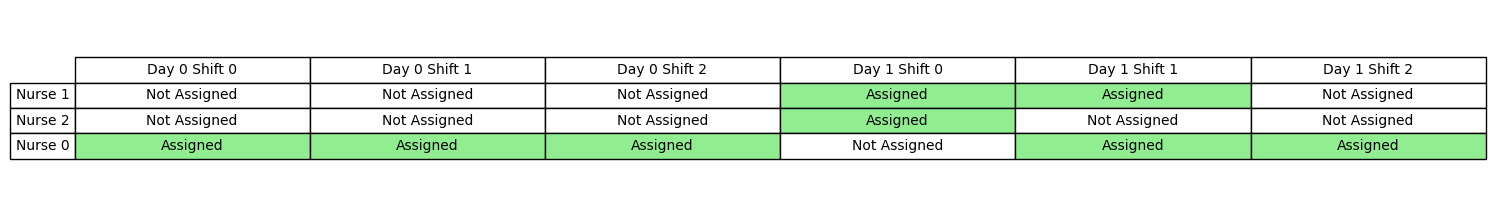

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,0,0])]
Size of CL:  24
Size of B:  1
Number of queries:  56
MQuAcq-2 Queries:  54
FindScope Queries:  0
FindC Queries:  2
Query56: is this a solution?


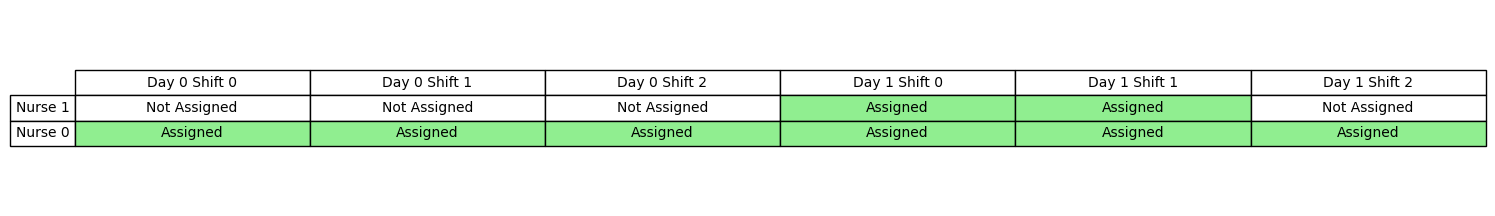

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,0,1])]

Learned 25 constraints in 57 queries.
C_L:  25
B:  0
Number of queries:  57
Top level Queries:  55
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,2,0] in GrowAcq
size of B in growacq:  60

GrowAcq: calling inner_algorithm for 11/12 variables
Size of CL:  25
Size of B:  60
Number of queries:  57
MQuAcq-2 Queries:  55
FindScope Queries:  0
FindC Queries:  2
Query57: is this a solution?


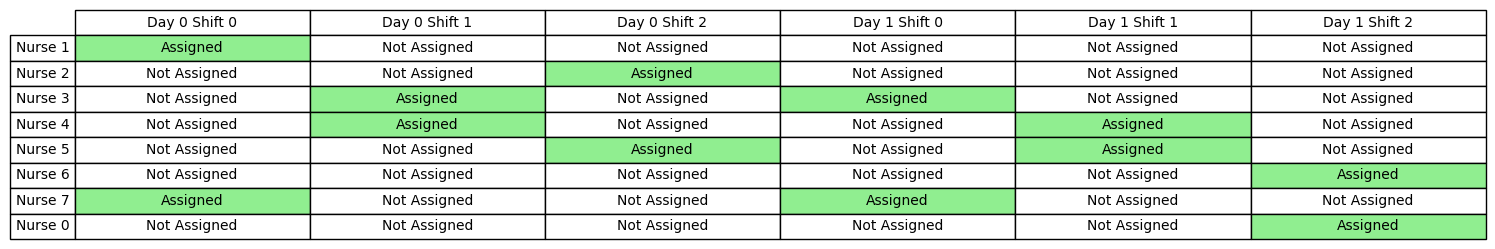

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) == (shifts[1,1,1]), (shifts[1,2,0]) == (shifts[1,0,1]), (shifts[1,2,0]) == (shifts[0,1,0]), (shifts[1,2,0]) == (shifts[1,1,0]), (shifts[1,2,0]) == (shifts[0,2,0]), (shifts[1,2,0]) == (shifts[0,2,1]), (shifts[1,2,0]) == (shifts[1,0,0]), (shifts[1,2,0]) == (shifts[0,0,1]), (shifts[1,2,0]) == (shifts[0,0,0]), (shifts[1,2,0]) == (shifts[0,1,1]), (shifts[1,2,0]) < (shifts[1,1,1]), (shifts[1,2,0]) < (shifts[0,1,0]), (shifts[1,2,0]) < (shifts[1,1,0]), (shifts[1,2,0]) < (shifts[0,2,0]), (shifts[1,2,0]) < (shifts[0,2,1]), (shifts[1,2,0]) < (shifts[1,0,0]), (shifts[1,2,0]) < (shifts[0,0,0]), (shifts[1,2,0]) < (shifts[0,1,1]), (shifts[1,2,0]) > (shifts[1,0,1]), (shifts[1,2,0]) > (shifts[0,0,1]), (shifts[1,2,0]) >= (shifts[1,0,1]), (shifts[1,2,0]) >= (shifts[0,0,1]), (shifts[1,2,0]) <= (shifts[1,1,1]), (shifts[1,2,0]) <= (shifts[0,1,0]), (shifts[1,2,0]) <= (shifts[1,1,0]), (shifts[1,2,0]) <= (shifts[0,2,0]), (shifts[1,2,0]

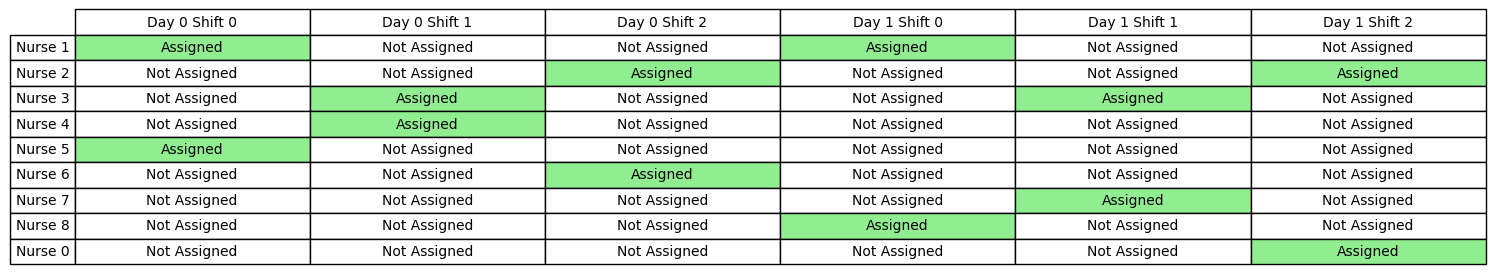

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) <= (shifts[1,0,1]), (shifts[1,2,0]) <= (shifts[0,0,1]), (shifts[1,2,0]) > (shifts[0,2,0]), (shifts[1,2,0]) > (shifts[1,0,0]), (shifts[1,2,0]) >= (shifts[0,2,0]), (shifts[1,2,0]) > (shifts[0,1,0]), (shifts[1,2,0]) > (shifts[1,1,0]), (shifts[1,2,0]) >= (shifts[0,0,0]), (shifts[1,2,0]) >= (shifts[1,1,1]), (shifts[1,2,0]) >= (shifts[1,1,0]), (shifts[1,2,0]) >= (shifts[1,0,0]), (shifts[1,2,0]) > (shifts[0,0,0]), (shifts[1,2,0]) > (shifts[1,1,1]), (shifts[1,2,0]) < (shifts[1,0,1]), (shifts[1,2,0]) < (shifts[0,0,1]), (shifts[1,2,0]) > (shifts[0,1,1]), (shifts[1,2,0]) >= (shifts[0,1,1]), (shifts[1,2,0]) >= (shifts[0,1,0]), (shifts[1,2,0]) != (shifts[0,2,1]), (shifts[1,2,0]) > (shifts[0,2,1])]
Size of CL:  25
Size of B:  10
Number of queries:  59
MQuAcq-2 Queries:  57
FindScope Queries:  0
FindC Queries:  2
Query59: is this a solution?


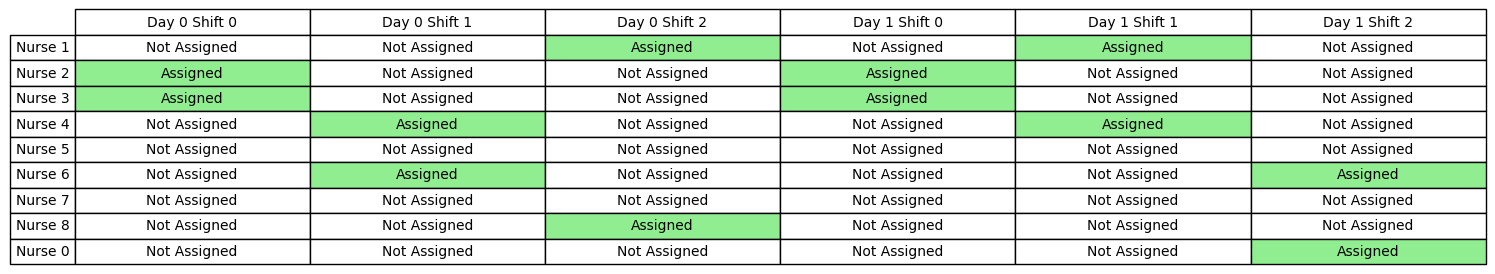

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) != (shifts[0,1,1]), (shifts[1,2,0]) >= (shifts[0,2,1])]
Size of CL:  25
Size of B:  8
Number of queries:  60
MQuAcq-2 Queries:  58
FindScope Queries:  0
FindC Queries:  2
Query60: is this a solution?


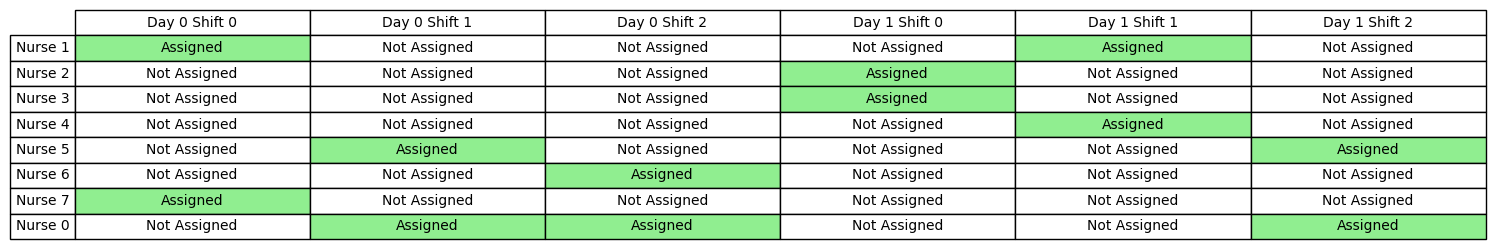

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) != (shifts[0,1,0])]
Size of CL:  25
Size of B:  7
Number of queries:  61
MQuAcq-2 Queries:  59
FindScope Queries:  0
FindC Queries:  2
Query61: is this a solution?


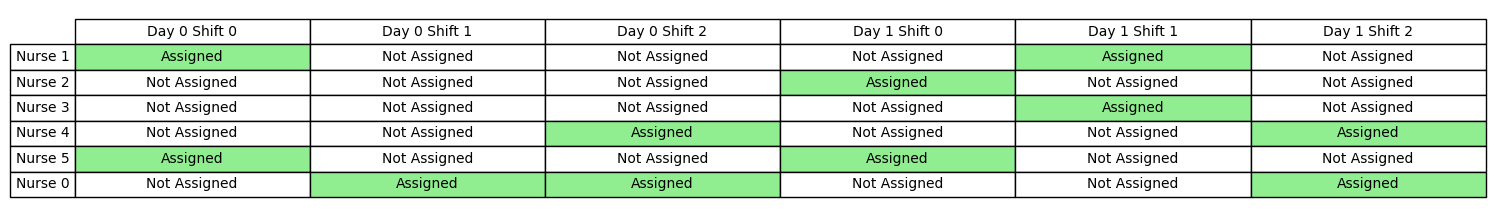

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) != (shifts[0,2,0])]
Size of CL:  25
Size of B:  6
Number of queries:  62
MQuAcq-2 Queries:  60
FindScope Queries:  0
FindC Queries:  2
Query62: is this a solution?


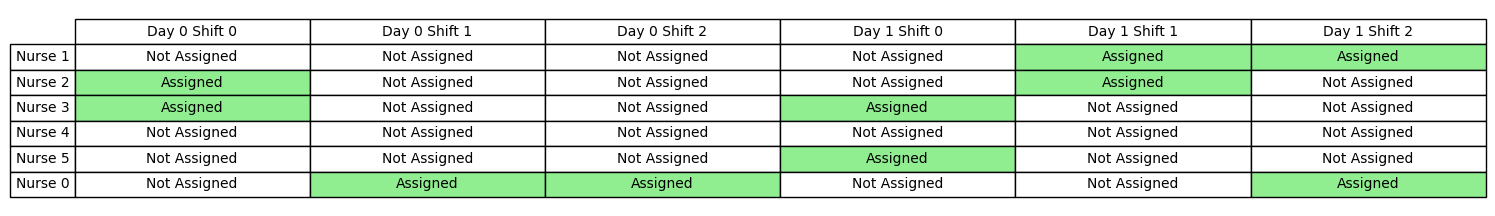

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,1,1])]
Size of CL:  26
Size of B:  5
Number of queries:  63
MQuAcq-2 Queries:  61
FindScope Queries:  0
FindC Queries:  2
Query63: is this a solution?


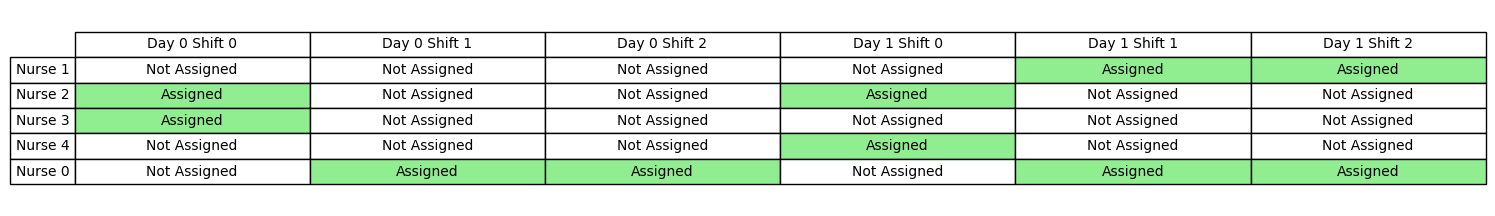

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,1,0])]
Size of CL:  27
Size of B:  4
Number of queries:  64
MQuAcq-2 Queries:  62
FindScope Queries:  0
FindC Queries:  2
Query64: is this a solution?


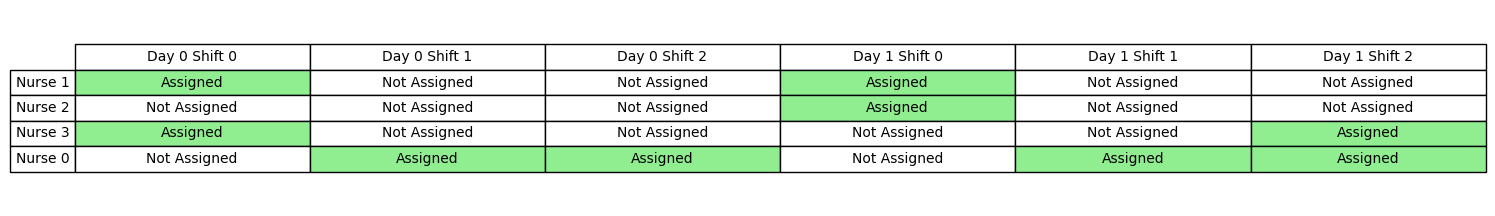

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) != (shifts[0,0,0])]
Size of CL:  27
Size of B:  3
Number of queries:  65
MQuAcq-2 Queries:  63
FindScope Queries:  0
FindC Queries:  2
Query65: is this a solution?


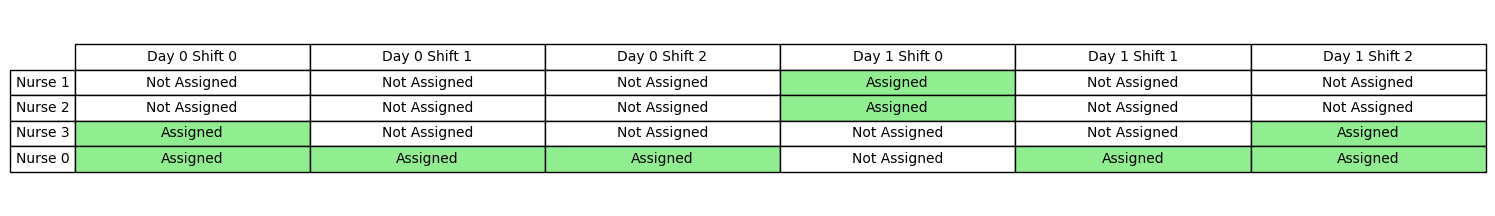

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) != (shifts[0,0,1])]
Size of CL:  27
Size of B:  2
Number of queries:  66
MQuAcq-2 Queries:  64
FindScope Queries:  0
FindC Queries:  2
Query66: is this a solution?


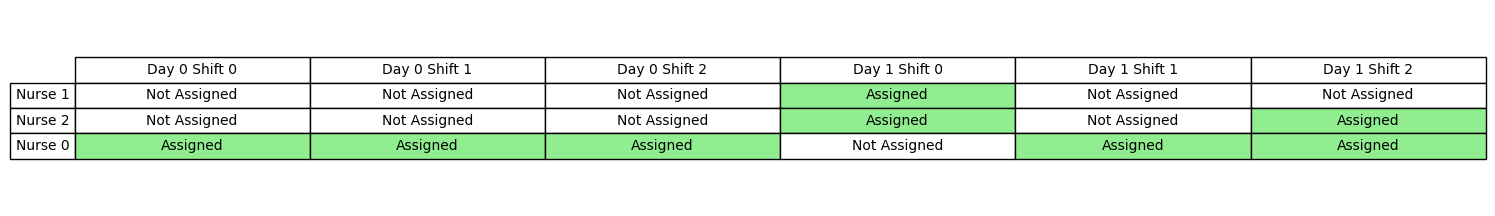

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,0,1])]
Size of CL:  28
Size of B:  1
Number of queries:  67
MQuAcq-2 Queries:  65
FindScope Queries:  0
FindC Queries:  2
Query67: is this a solution?


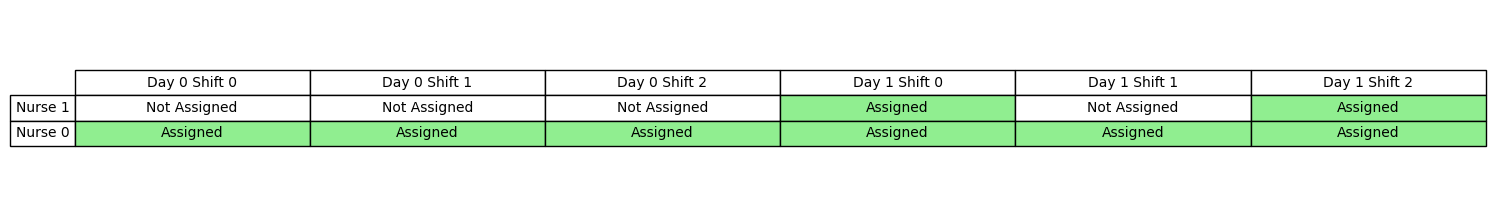

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,0,0])]

Learned 29 constraints in 68 queries.
C_L:  29
B:  0
Number of queries:  68
Top level Queries:  66
FindScope Queries:  0
FindC Queries:  2
Added variable shifts[1,2,1] in GrowAcq
size of B in growacq:  66

GrowAcq: calling inner_algorithm for 12/12 variables
Size of CL:  29
Size of B:  66
Number of queries:  68
MQuAcq-2 Queries:  66
FindScope Queries:  0
FindC Queries:  2
Query68: is this a solution?


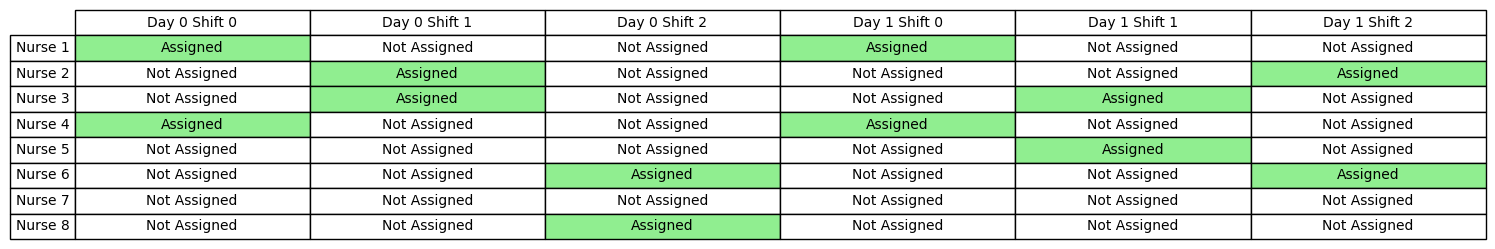

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) == (shifts[1,1,1]), (shifts[1,2,1]) == (shifts[1,0,1]), (shifts[1,2,1]) == (shifts[1,2,0]), (shifts[1,2,1]) == (shifts[0,1,0]), (shifts[1,2,1]) == (shifts[1,1,0]), (shifts[1,2,1]) == (shifts[0,2,1]), (shifts[1,2,1]) == (shifts[1,0,0]), (shifts[1,2,1]) == (shifts[0,0,1]), (shifts[1,2,1]) == (shifts[0,0,0]), (shifts[1,2,1]) == (shifts[0,1,1]), (shifts[1,2,1]) != (shifts[0,2,0]), (shifts[1,2,1]) < (shifts[1,1,1]), (shifts[1,2,1]) < (shifts[1,0,1]), (shifts[1,2,1]) < (shifts[1,2,0]), (shifts[1,2,1]) < (shifts[0,1,0]), (shifts[1,2,1]) < (shifts[1,1,0]), (shifts[1,2,1]) < (shifts[0,2,0]), (shifts[1,2,1]) < (shifts[1,0,0]), (shifts[1,2,1]) < (shifts[0,0,1]), (shifts[1,2,1]) < (shifts[0,0,0]), (shifts[1,2,1]) < (shifts[0,1,1]), (shifts[1,2,1]) > (shifts[0,2,0]), (shifts[1,2,1]) > (shifts[0,2,1]), (shifts[1,2,1]) >= (shifts[0,2,1]), (shifts[1,2,1]) <= (shifts[1,1,1]), (shifts[1,2,1]) <= (shifts[1,0,1]), (shifts[1,2,1]) 

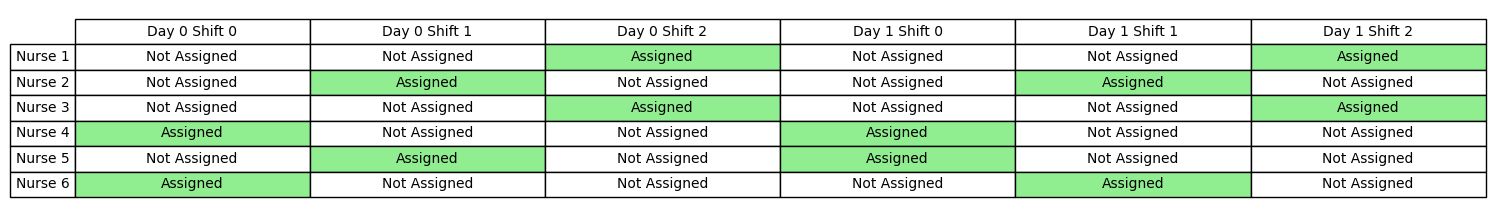

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,2,1]), (shifts[1,2,1]) > (shifts[0,1,1]), (shifts[1,2,1]) >= (shifts[1,1,0]), (shifts[1,2,1]) > (shifts[1,2,0]), (shifts[1,2,1]) >= (shifts[1,1,1]), (shifts[1,2,1]) > (shifts[1,1,1]), (shifts[1,2,1]) >= (shifts[0,0,0]), (shifts[1,2,1]) >= (shifts[1,0,1]), (shifts[1,2,1]) > (shifts[1,1,0]), (shifts[1,2,1]) > (shifts[0,0,1]), (shifts[1,2,1]) >= (shifts[0,2,0]), (shifts[1,2,1]) >= (shifts[0,0,1]), (shifts[1,2,1]) > (shifts[1,0,0]), (shifts[1,2,1]) > (shifts[0,0,0]), (shifts[1,2,1]) >= (shifts[1,0,0]), (shifts[1,2,1]) >= (shifts[1,2,0]), (shifts[1,2,1]) > (shifts[0,1,0]), (shifts[1,2,1]) >= (shifts[0,1,0]), (shifts[1,2,1]) == (shifts[0,2,0]), (shifts[1,2,1]) > (shifts[1,0,1]), (shifts[1,2,1]) < (shifts[0,2,1]), (shifts[1,2,1]) >= (shifts[0,1,1])]
Size of CL:  29
Size of B:  11
Number of queries:  70
MQuAcq-2 Queries:  68
FindScope Queries:  0
FindC Queries:  2
Query70: is this a solution?


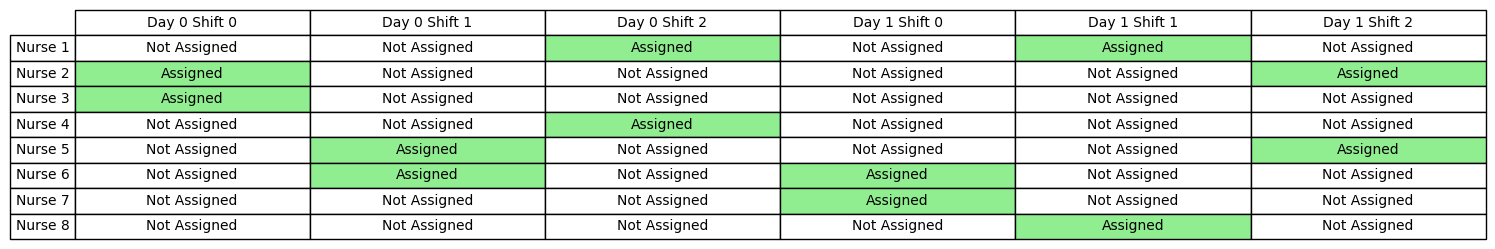

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) <= (shifts[0,2,1]), (shifts[1,2,1]) <= (shifts[0,2,0]), (shifts[1,2,1]) != (shifts[0,1,0])]
Size of CL:  29
Size of B:  8
Number of queries:  71
MQuAcq-2 Queries:  69
FindScope Queries:  0
FindC Queries:  2
Query71: is this a solution?


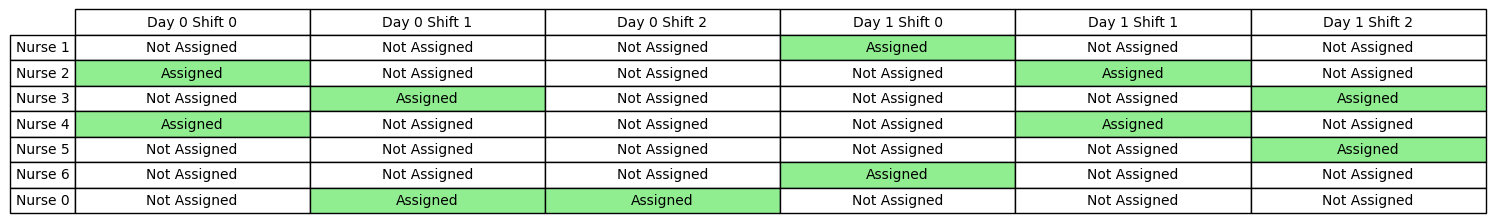

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,1,1])]
Size of CL:  29
Size of B:  7
Number of queries:  72
MQuAcq-2 Queries:  70
FindScope Queries:  0
FindC Queries:  2
Query72: is this a solution?


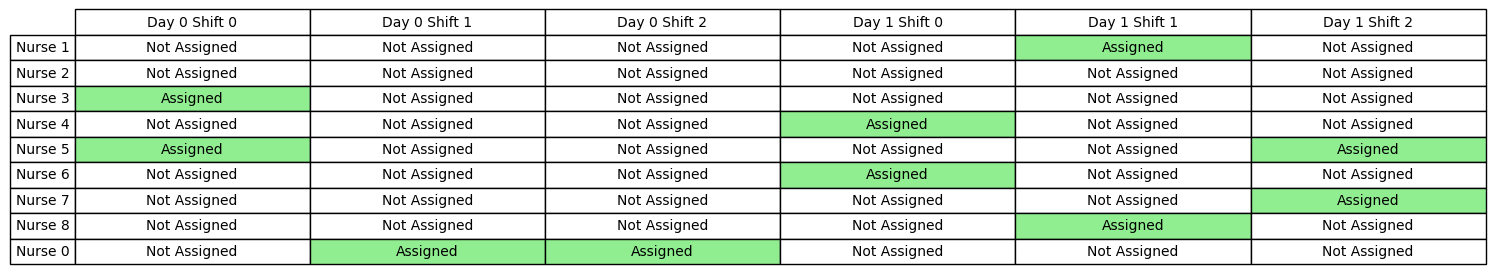

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,0,0])]
Size of CL:  29
Size of B:  6
Number of queries:  73
MQuAcq-2 Queries:  71
FindScope Queries:  0
FindC Queries:  2
Query73: is this a solution?


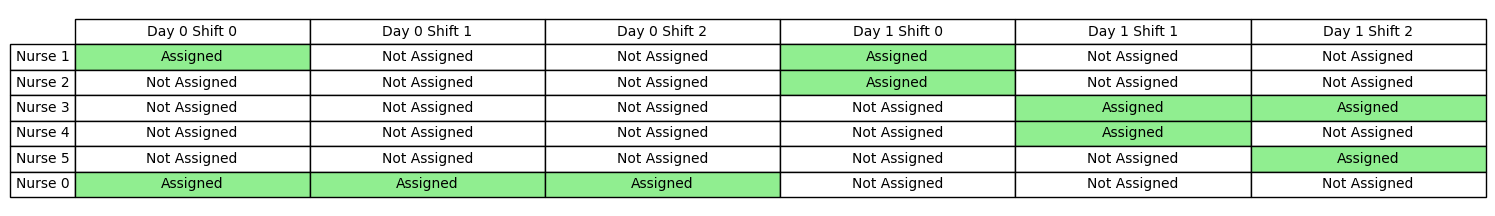

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,1,0])]
Size of CL:  30
Size of B:  5
Number of queries:  74
MQuAcq-2 Queries:  72
FindScope Queries:  0
FindC Queries:  2
Query74: is this a solution?


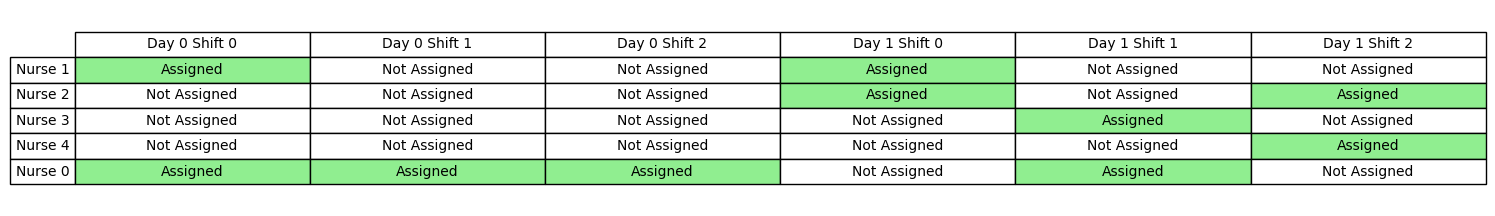

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,0,1])]
Size of CL:  31
Size of B:  4
Number of queries:  75
MQuAcq-2 Queries:  73
FindScope Queries:  0
FindC Queries:  2
Query75: is this a solution?


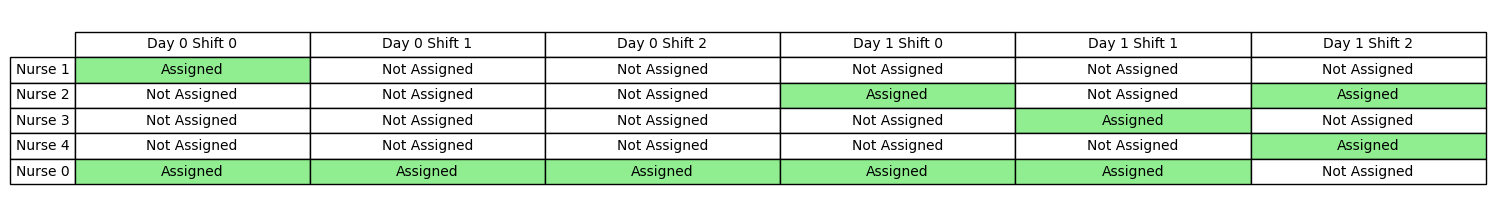

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,0,0])]
Size of CL:  32
Size of B:  3
Number of queries:  76
MQuAcq-2 Queries:  74
FindScope Queries:  0
FindC Queries:  2
Query76: is this a solution?


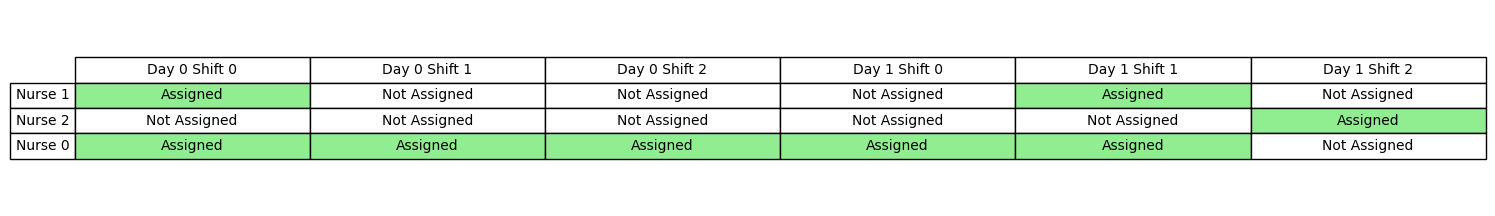

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,2,0])]
Size of CL:  33
Size of B:  2
Number of queries:  77
MQuAcq-2 Queries:  75
FindScope Queries:  0
FindC Queries:  2
Query77: is this a solution?


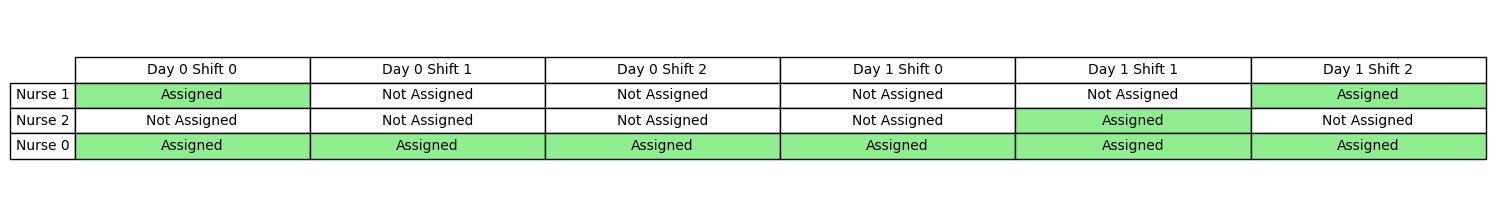

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,1]) != (shifts[0,0,1])]
Size of CL:  33
Size of B:  1
Number of queries:  78
MQuAcq-2 Queries:  76
FindScope Queries:  0
FindC Queries:  2
Query78: is this a solution?


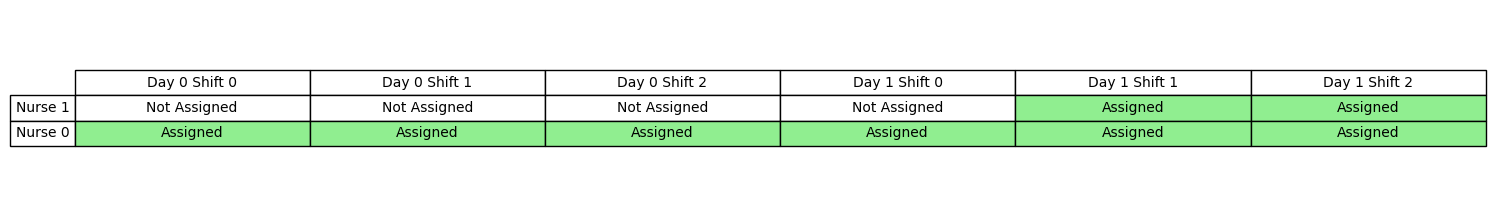

Answer:  No
adding the following constraints to C_L: [(shifts[1,2,1]) != (shifts[1,1,1])]

Learned 34 constraints in 79 queries.
C_L:  34
B:  0
Number of queries:  79
Top level Queries:  77
FindScope Queries:  0
FindC Queries:  2
Number of queries:  79
Number of recommendation queries:  0
Number of generalization queries:  0
Top level Queries:  77
FindScope Queries:  0
FindC Queries:  2


In [15]:
learned_instance = ca.learn(instance, oracle, verbose=3)

In the "Prediction-based CA System" notebook you can see how to run even better CA systems...